In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.interpolate import interp1d
from scipy.interpolate import griddata
from scipy import interpolate
import matplotlib.pylab as pl
#import seaborn as sns
import matplotlib.colors as mcolors
import matplotlib.colors as colors

plt.style.use('../../Paul_style.txt')
#plt.rcParams["font.family"] = "Serif"

nlat = 48
nlon = 96
nlev = 50

In [36]:
linestyles = ['solid', 'solid', 'solid', 'solid', 'solid', 'solid', 
            'dashed','dashed','dashed','dashed','dashed','dashed'] 
linestyles = ['solid', 'solid', 'solid',
              'dashed','dashed','dashed'] 
colors = ['black', '#7e1e9c', '#40a368',
          'black', '#7e1e9c', '#40a368']
labels = ['DG, Clear',
          'DG, Nuc. Clouds', 
          'DG, Nuc. Clouds, Comp.',
          'PF, Clear',
          'PF, Nuc. Clouds', 
          'PF, Nuc. Clouds, Comp.']

In [37]:
def get_planet_df(planet_name, nlat, nlon, nlev, base):
    runfile = base + planet_name + '/Planet_Run/fort.62'

    # This is for the top of the weird column thing
    skip = 9
    latlon  = np.empty([nlat*nlon,2]) # to hold the latitude and longitude values at each location
    swout   = np.empty([nlat*nlon])    # to hold the upward SW flux at each location (out the top of the atmosphere)
    swin   = np.empty([nlat*nlon])    # to hold the upward SW flux at each location (out the top of the atmosphere)

    llind   = np.linspace(nlev+13,nlev+13+(nlat*nlon-2)*(nlev+11),num=nlat*nlon-1)
    llextra = np.array([2])
    llind   = np.concatenate((llextra,llind))                  # ugh, have to grab the right lines for lat, lon
    swind   = np.linspace(skip,skip+(nlat*nlon-1)*(nlev+11),num=nlat*nlon)  # ugh, it's different for some reason here
    
    
    i = 0
    l=0
    ind=0
    with open(runfile) as f:
        for line in f:            
            if l in llind:
                toss1,toss2,lat,lon=line.split()
                latlon[ind,:]=[np.float32(lat),np.float32(lon)]
            elif l in swind:
                sw,sw_in_val =line.split()
                swout[ind]=sw
                swin[ind] = sw_in_val
                ind+=1
            l+=1
    f.close()

    lats = latlon[:,0]
    lons = latlon[:,1]
    
    df_lw = pd.read_csv('../Spectral-Processing/GCM-OUTPUT/' + planet_name +'/Planet_Run/fort.64',
                     delim_whitespace=True, 
                     skiprows=1,
                     skipfooter=1,
                     names=['lon', 'lat', 'lwout'],
                     engine='python')
    
    df_sw = pd.DataFrame({'lat': lats,
                          'lon': lons,
                          'swout': swout,
                          'swin': swin})
    
    df_sw['lat'] = df_sw['lat'].astype(float).round(2)
    df_lw['lat'] = df_lw['lat'].astype(float).round(2)
    df = df_lw.merge(df_sw, on=["lat","lon"])
    
    return df


def get_phase_curve(df, nlat=48, nlon=96, nlev=50):
    df['swout_temp'] = df['swout'] * np.cos((df['lat'] * (np.pi / 180.0))) ** 2.0
    df['lwout_temp'] = df['lwout'] * np.cos((df['lat'] * (np.pi / 180.0))) ** 2.0
    df['swin_temp']  = df['swin'] * np.cos((df['lat'] * (np.pi / 180.0))) ** 2.0
    
    df['vis_temp'] = np.cos((df['lat'] * (np.pi / 180.0))) ** 2.0

    lon_df = df.groupby("lon").sum().reset_index()
    lon_df = lon_df.drop(['lat'], axis=1)

    # The arrays with the completed phase curves
    lw_phase_curve  = []
    sw_phase_curve  = []
    vis_phase_curve = []
    sw_in_phase_curve = []

    # For every lon, sum all the visible fluxes 
    for i, lon in enumerate(list(np.unique(lon_df.lon))):
        # Get the fraction that's normal to the observer for each lon
        lon_df['normal'] = np.cos((lon_df.lon - lon) * (np.pi / 180.))

        # Multiply the sw flux and the lw flux by that normal value
        lon_df['sw_final']  = lon_df['swout_temp'] * lon_df['normal']
        lon_df['lw_final']  = lon_df['lwout_temp'] * lon_df['normal']
        lon_df['vis_final'] = lon_df['vis_temp'] * lon_df['normal']
        
        lon_df['swin_final']  = lon_df['swin_temp'] * lon_df['normal']

        # Using the neat cos function, any value that's negative is not visible
        # Sum all the visible points
        lw_phase_curve.append(sum(filter(lambda x: x>=0, list(lon_df.lw_final))))
        sw_phase_curve.append(sum(filter(lambda x: x>=0, list(lon_df.sw_final))))
        
        sw_in_phase_curve.append(sum(filter(lambda x: x>=0, list(lon_df.swin_final))))
        
        vis_phase_curve.append(sum(filter(lambda x: x>=0, list(lon_df.vis_final))))

    # Divide by the visible area thing
    
    sw_curve_final = []
    lw_curve_final = []
    swin_curve_final = []
    for i in range(len(lw_phase_curve)):
        sw_curve_final.append(sw_phase_curve[i] / vis_phase_curve[i])
        lw_curve_final.append(lw_phase_curve[i] / vis_phase_curve[i])
        
        swin_curve_final.append(sw_in_phase_curve[i] / vis_phase_curve[i])

    
    return lw_curve_final, sw_curve_final, swin_curve_final, lon_df
    #return None
    
def get_fort62_df(planet_name, nlat, nlon, nlev, base):
    runfile = base + planet_name + '/Planet_Run/fort.62'

    # This is for the top of the weird column thing
    skip = 11
    latlon  = np.empty([nlat*nlon,2]) # to hold the latitude and longitude values at each location
    w0_sw   = np.empty([nlat*nlon])    # to hold the upward SW flux at each location (out the top of the atmosphere)

    llind   = np.linspace(nlev+13,nlev+13+(nlat*nlon-2)*(nlev+11),num=nlat*nlon-1)
    llextra = np.array([2])
    llind   = np.concatenate((llextra,llind))                  # ugh, have to grab the right lines for lat, lon
    swind   = np.linspace(skip,skip+(nlat*nlon-1)*(nlev+11),num=nlat*nlon)  # ugh, it's different for some reason here
    
    
    i = 0
    l=0
    ind=0
    with open(runfile) as f:
        for i, line in enumerate(f):            
            if l in llind:
                toss1,toss2,lat,lon=line.split()
                latlon[ind,:]=[np.float32(lat),np.float32(lon)]
            elif l in swind:
                pressure, tau_sw, tau_lw, tauc_sw, tauc_lw, w0_sw_val, w0_lw_val, g0_sw, g0_lw, direct_sw, direct_lw, intensity = line.split()                
                w0_sw[ind]=w0_sw_val
                ind+=1
            l+=1
            
            #if (i > 500):
            #    break
            
    f.close()

    lats = latlon[:,0]
    lons = latlon[:,1]
    
    
    df = pd.DataFrame({'lat': lats,
                        'lon': lons,
                        'w0_sw': w0_sw})
    
    return df

BA (sw out / sw in): 0.01
BA (sw out / sw in): 0.22
BA (sw out / sw in): 0.28
BA (sw out / sw in): 0.01
BA (sw out / sw in): 0.01
BA (sw out / sw in): 0.09


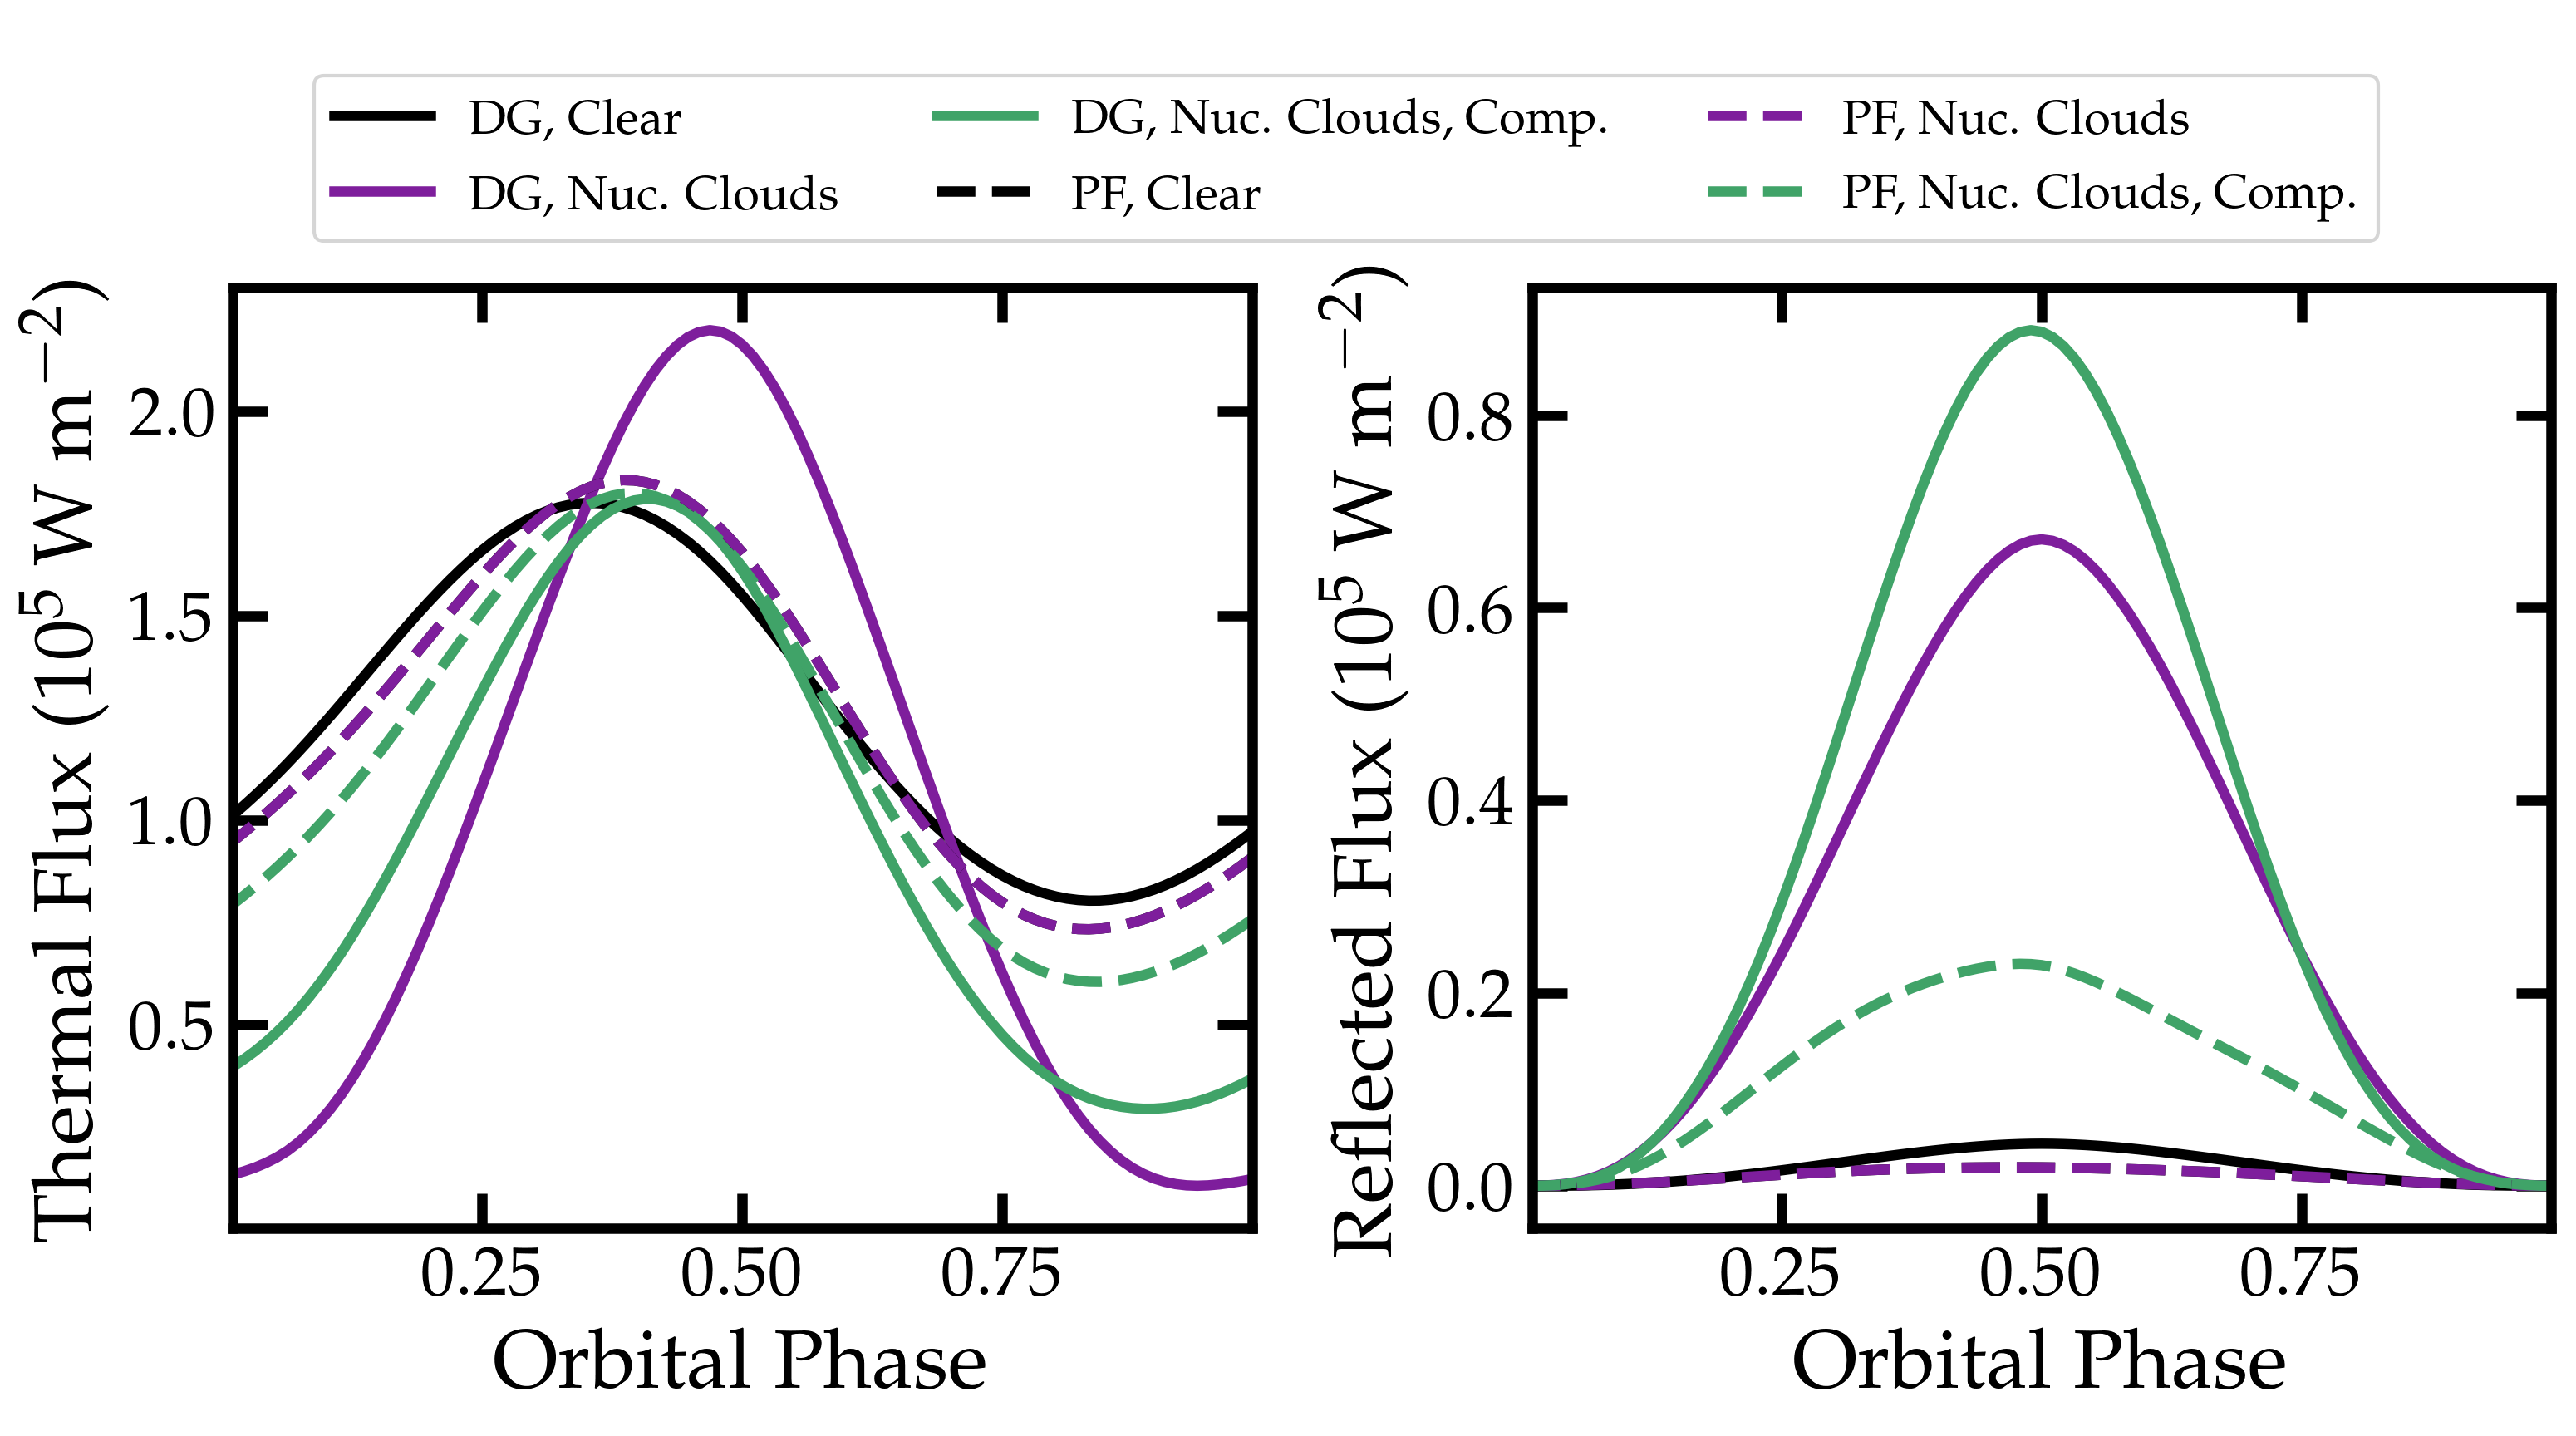

In [38]:
planet_names = ['HD189-DOGRAY',
                'HD189-DOGRAY-ALL-CLOUDS',
                'HD189-DOGRAY-ALL-CLOUDS-COMPACT',
                'HD189-PICKET',
                'HD189-PICKET-ALL-CLOUDS',
                'HD189-PICKET-ALL-CLOUDS-COMPACT']
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5), sharex=True, sharey=False)
plt.subplots_adjust(wspace=0.275, hspace=0.1)

energy_out_thermal = []     
energy_out_sw      = []
energy_in_sw       = []

for j, planet_name in enumerate(planet_names):
    df = get_planet_df(planet_names[j], nlat=48, nlon=96, nlev=50,base='../Spectral-Processing/GCM-OUTPUT/')
    lw_phase_curve, sw_phase_curve, swin_phase_curve, lon_df = get_phase_curve(df)
    
    energy_out_thermal.append(sum(lw_phase_curve))
    energy_out_sw.append(sum(sw_phase_curve))
    energy_in_sw.append(sum(swin_phase_curve))

    # Plot each phase curve
    ax[0].plot(lon_df.lon / 360.0, np.roll(lw_phase_curve[::-1], nlat) / 1e5,
               color=colors[j], linewidth=3, label=labels[j], linestyle=linestyles[j]) 
    ax[1].plot(lon_df.lon / 360.0, np.roll(sw_phase_curve, nlat) / 1e5,
               color=colors[j], linewidth=3,linestyle=linestyles[j])  
    
for i in range(len(energy_out_thermal)):
    print ("BA (sw out / sw in):", np.round(energy_out_sw[i] / energy_in_sw[i], 2))
    
fig.legend(ncol=3, fontsize=14,bbox_to_anchor=[0.45, 1.025], loc='center')

ax[0].set_xlim(0.01,0.99)
ax[1].set_xlim(0.01,0.99)
ax[0].set_xlabel('Orbital Phase', fontsize=24)
ax[1].set_xlabel('Orbital Phase', fontsize=24)
ax[0].set_ylabel(r'Thermal Flux (10$^5$ W m$^{-2}$)', fontsize=24)
ax[1].set_ylabel(r'Reflected Flux (10$^5$ W m$^{-2}$)', fontsize=24)

plt.savefig('../Figures/HD189_phasecurves.png', bbox_inches='tight', dpi=100)

In [39]:
print (np.argmax(np.roll(sw_phase_curve, nlat)))
print (lon_df.lon[47] / 360.0)

46
0.4895833333333333


BA (sw out / sw in): 0.0063
BA (sw out / sw in): 0.0873
BA (sw out / sw in): 0.0842
BA (sw out / sw in): 0.0012
BA (sw out / sw in): 0.0474
BA (sw out / sw in): 0.0245


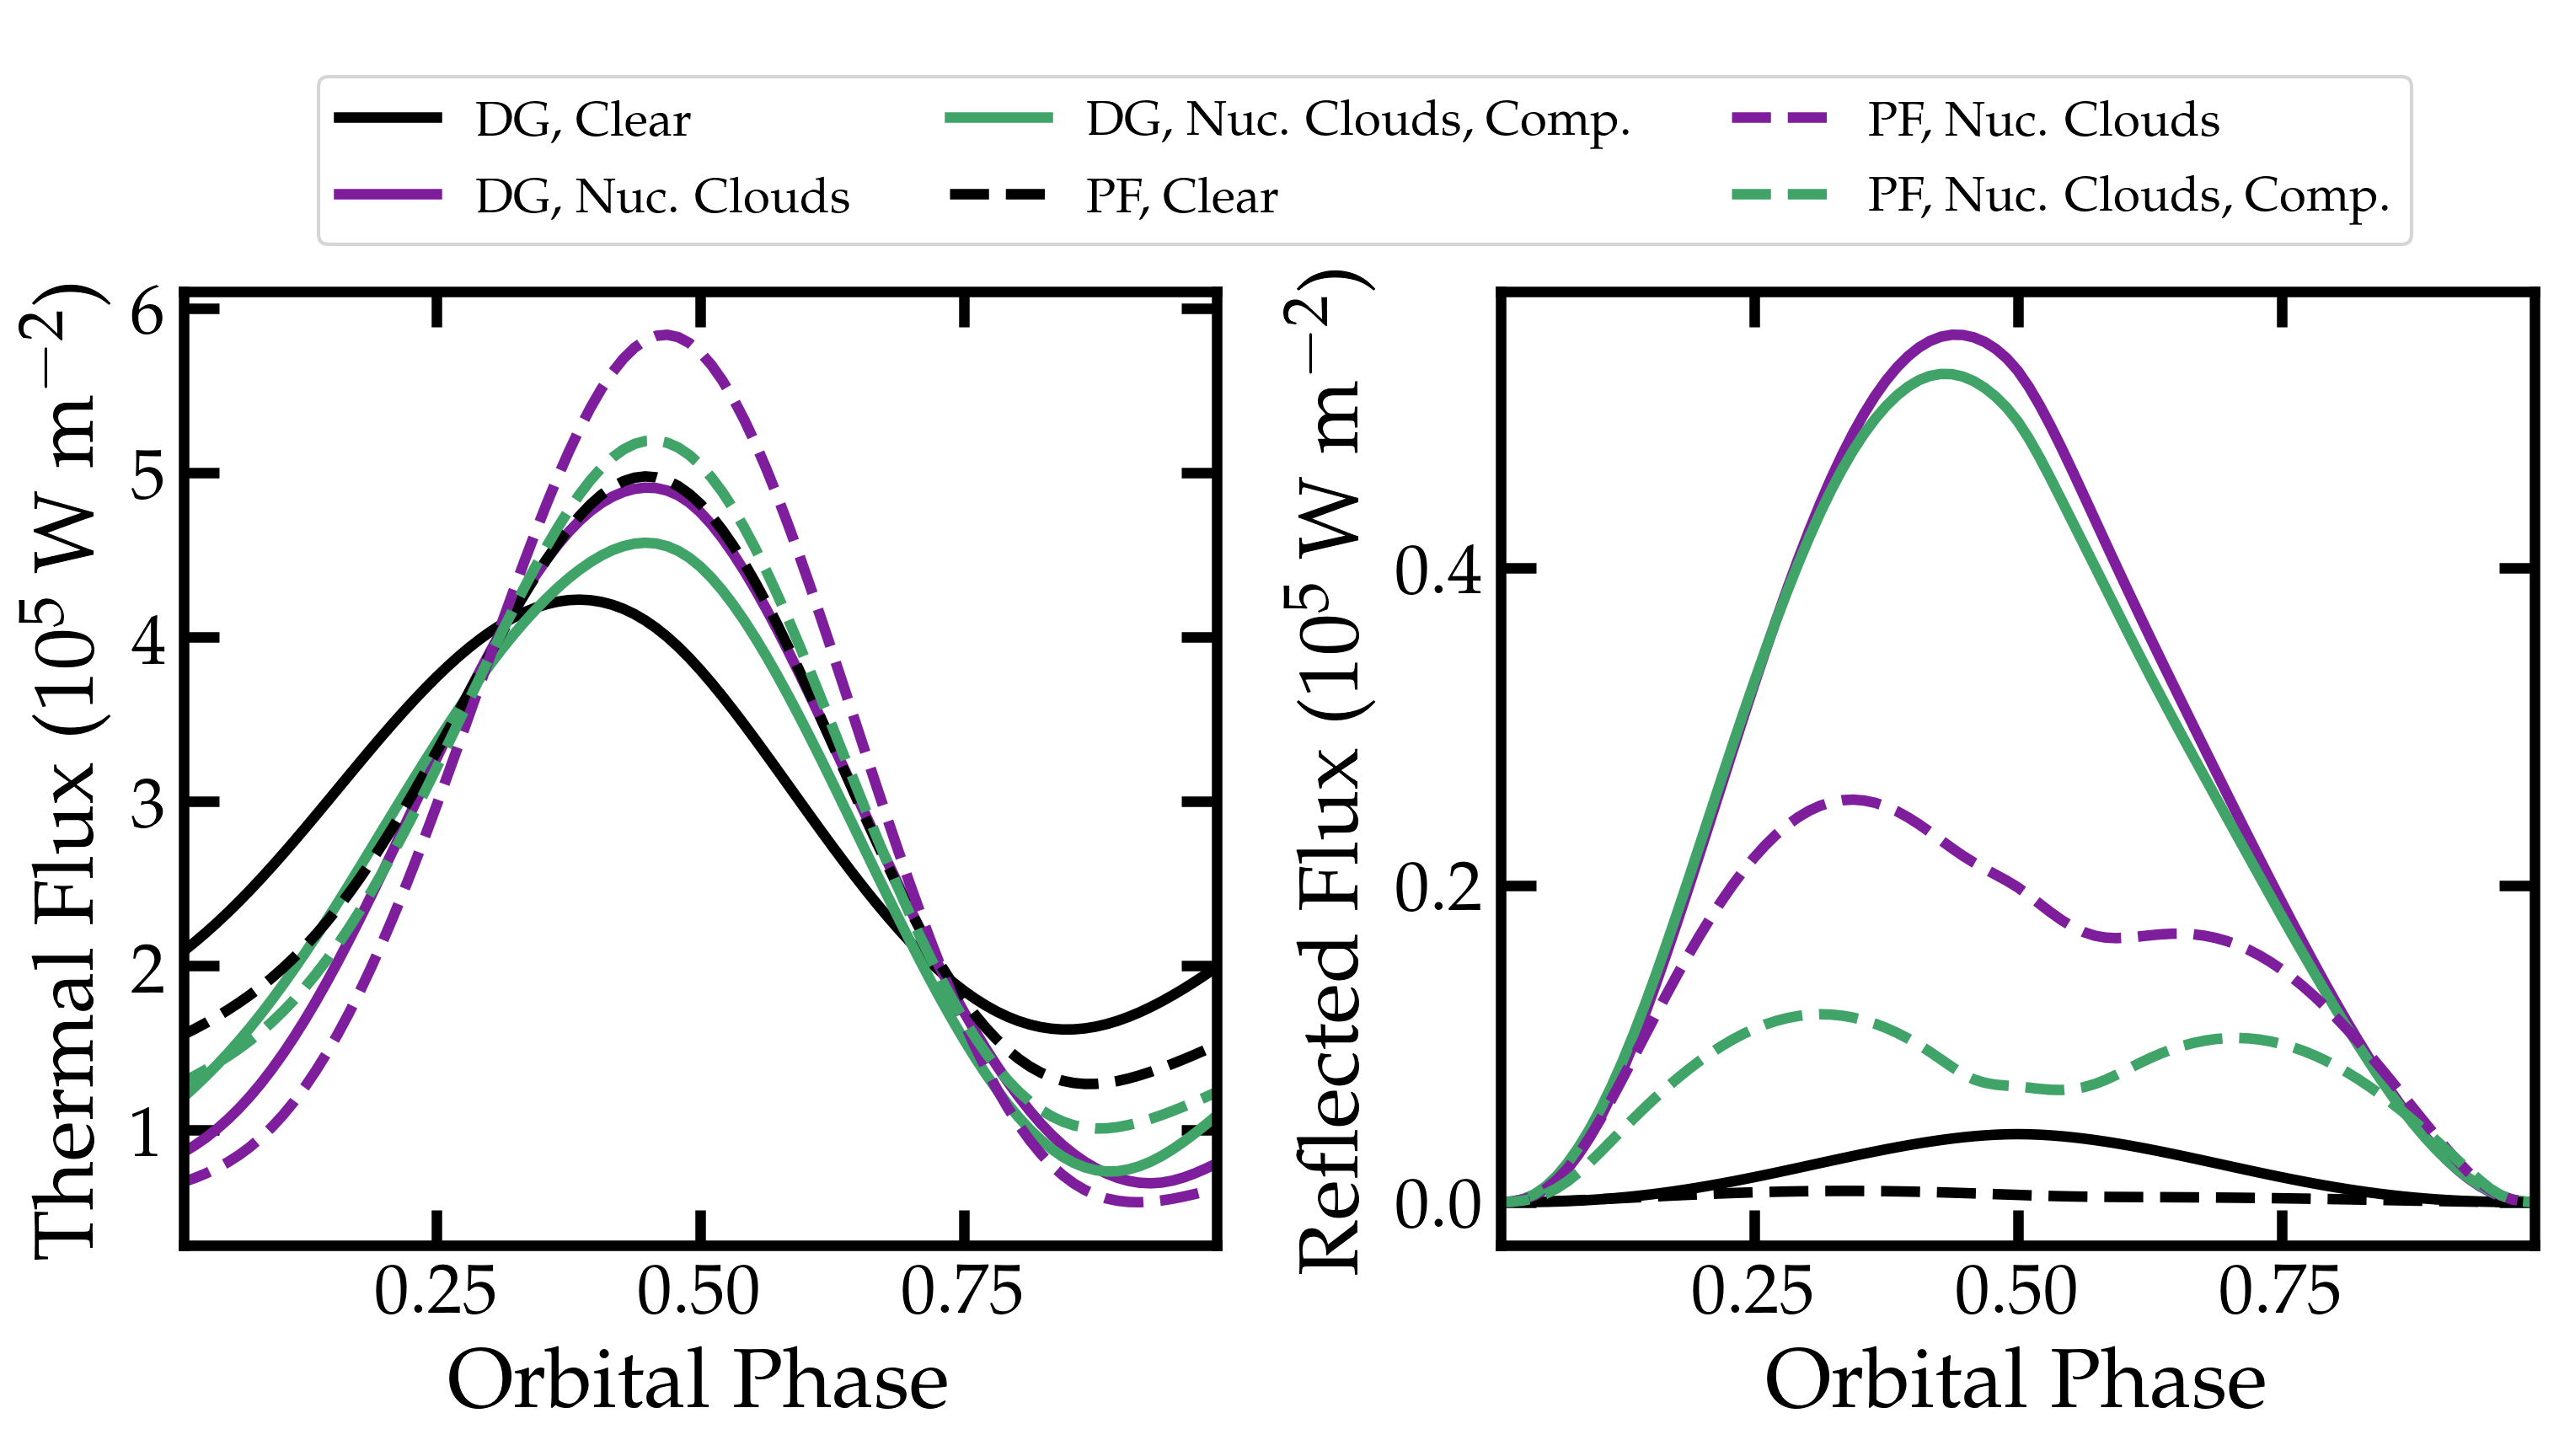

In [51]:
planet_names = ['HD209-DOGRAY',
                'HD209-DOGRAY-ALL-CLOUDS',
                'HD209-DOGRAY-ALL-CLOUDS-COMPACT',
                'HD209-PICKET',
                'HD209-PICKET-ALL-CLOUDS',
                'HD209-PICKET-ALL-CLOUDS-COMPACT']


fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5), sharex=True, sharey=False)
plt.subplots_adjust(wspace=0.275, hspace=0.1)


energy_out_thermal = []     
energy_out_sw      = []
energy_in_sw       = [] 
for j, planet_name in enumerate(planet_names):
    df = get_planet_df(planet_names[j], nlat=48, nlon=96, nlev=50,base='../Spectral-Processing/GCM-OUTPUT/')
    lw_phase_curve, sw_phase_curve, swin_phase_curve, lon_df = get_phase_curve(df)
    
    energy_out_thermal.append(sum(lw_phase_curve))
    energy_out_sw.append(sum(sw_phase_curve))
    energy_in_sw.append(sum(swin_phase_curve))

    # Plot each phase curve
    ax[0].plot(lon_df.lon / 360.0, np.roll(lw_phase_curve[::-1], nlat) / 1e5,
               color=colors[j], linewidth=3, label=labels[j], linestyle=linestyles[j]) 
    ax[1].plot(lon_df.lon / 360.0, np.roll(sw_phase_curve, nlat) / 1e5,
               color=colors[j], linewidth=3,linestyle=linestyles[j])  
    

for i in range(len(energy_out_thermal)):
    print ("BA (sw out / sw in):", np.round(energy_out_sw[i] / energy_in_sw[i], 4))
    

fig.legend(ncol=3, fontsize=14,bbox_to_anchor=[0.45, 1.025], loc='center')
#, borderaxespad=0.1,handleheight=1.6
#ax[0].set_yscale('log')
ax[0].set_xlim(0.01,0.99)
ax[1].set_xlim(0.01,0.99)
ax[0].set_xlabel('Orbital Phase', fontsize=24)
ax[1].set_xlabel('Orbital Phase', fontsize=24)
ax[0].set_ylabel(r'Thermal Flux (10$^5$ W m$^{-2}$)', fontsize=24)
ax[1].set_ylabel(r'Reflected Flux (10$^5$ W m$^{-2}$)', fontsize=24)

plt.savefig('../Figures/HD209_phasecurves.png', bbox_inches='tight', dpi=100)

In [41]:
print (np.argmax(np.roll(sw_phase_curve, nlat)))
print (lon_df.lon[43] / 360.0)

30
0.4479166666666667


Text(0.5, 1.0, 'Reflected')

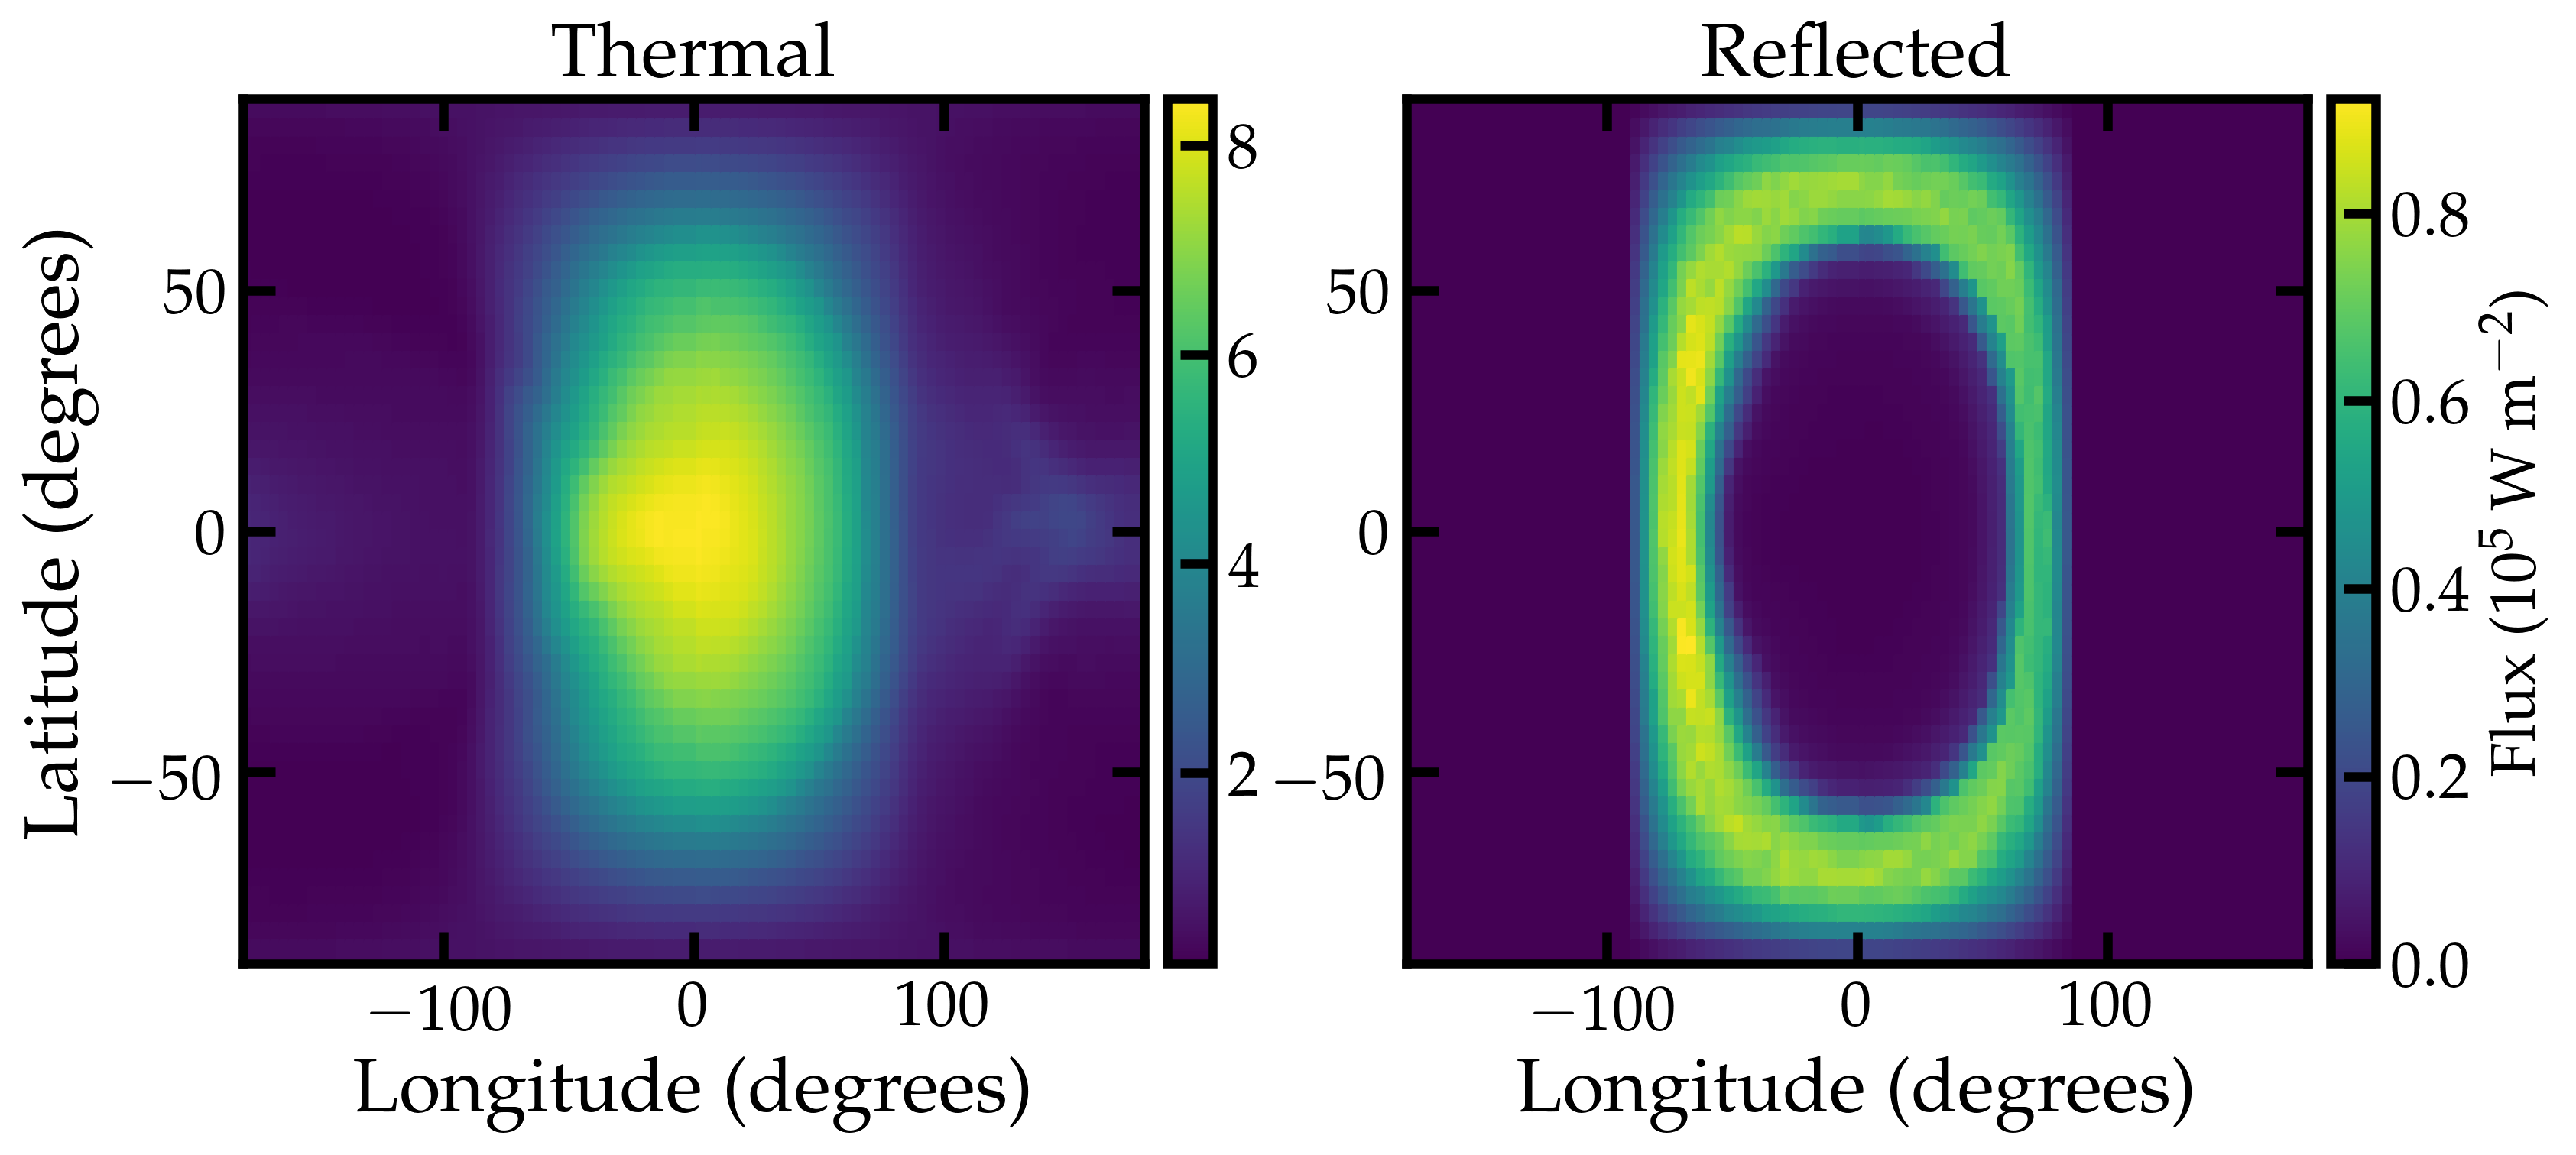

In [49]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5), sharex=True, sharey=False)
plt.subplots_adjust(wspace=0.2, hspace=0.1)


df = get_planet_df('HD209-PICKET-ALL-CLOUDS', nlat=48, nlon=96, nlev=50,base='../Spectral-Processing/GCM-OUTPUT/')
#df.lon = df.lon + 180.0
df.lon = df.lon.mask(df.lon >= 180.0, df.lon - 360.0)


thermal_map   = ax[0].scatter(df.lon, df.lat, c=df.lwout/1e5, marker='s')
divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='5%', pad=0.1)
cbar0 = fig.colorbar(thermal_map, cax=cax, orientation='vertical')
#cbar0.set_label(r'Flux (10$^5$ W m$^{-2}$)', fontsize=20)

reflected_map = ax[1].scatter(df.lon, df.lat, c=df.swout/1e5, marker='s')
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.1)
cbar1 = fig.colorbar(reflected_map, cax=cax, orientation='vertical')
cbar1.set_label(r'Flux (10$^5$ W m$^{-2}$)', fontsize=20)


ax[0].set_xlim(-180, 180)
ax[1].set_xlim(-180, 180)

ax[0].set_ylim(-90,90)
ax[1].set_ylim(-90,90)

ax[0].set_xlabel('Longitude (degrees)', fontsize=24)
ax[1].set_xlabel('Longitude (degrees)', fontsize=24)
ax[0].set_ylabel(r'Latitude (degrees)', fontsize=24)
#ax[1].set_ylabel(r'Lat', fontsize=24, labelpad=-15)

ax[0].set_title('Thermal', fontsize=24)
ax[1].set_title('Reflected', fontsize=24)

Text(0, 0.5, 'Latitude (degrees)')

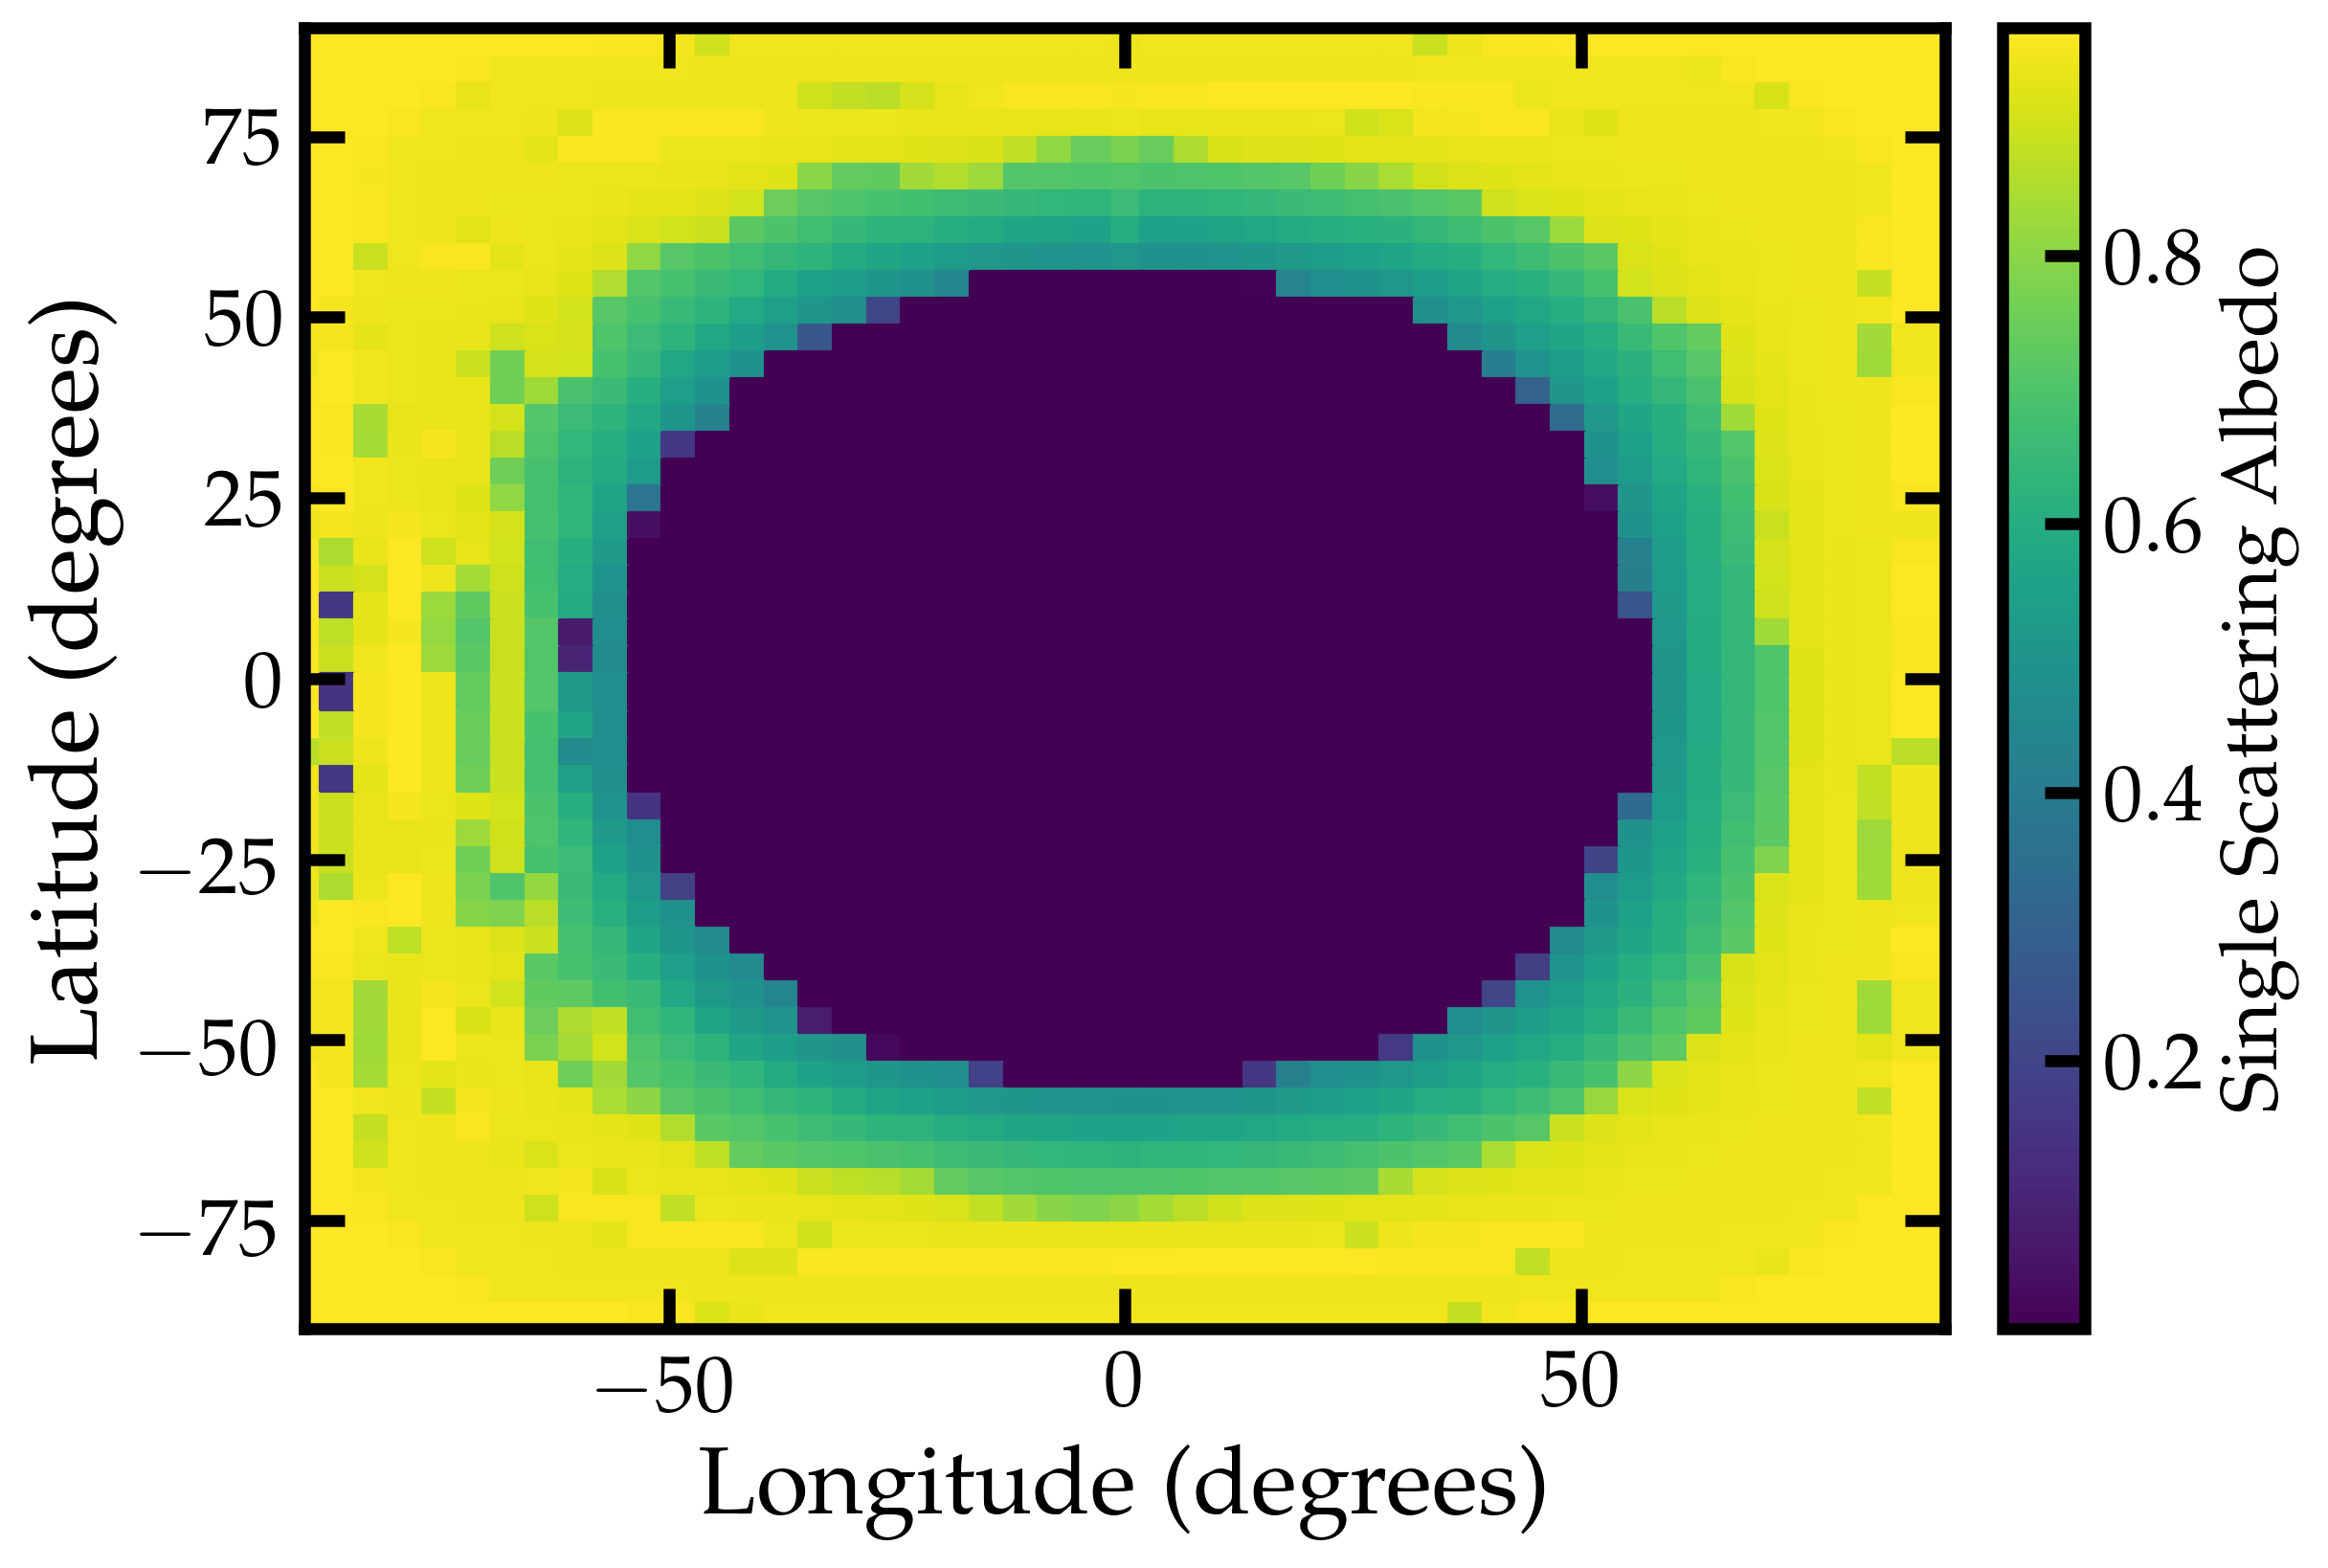

In [50]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,6), sharex=True, sharey=False)
plt.subplots_adjust(wspace=0.2, hspace=0.1)

df = get_fort62_df('HD209-PICKET-ALL-CLOUDS', nlat=48, nlon=96, nlev=50,base='../Spectral-Processing/GCM-OUTPUT/')
df.lon = df.lon.mask(df.lon >= 180.0, df.lon - 360.0)

w0_map   = ax.scatter(df.lon, df.lat, c=df.w0_sw, marker='s', s=80)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.2)
cbar0 = fig.colorbar(w0_map, cax=cax, orientation='vertical')
cbar0.set_label(r'Single Scattering Albedo', fontsize=20)

ax.set_xlim(-90,90)
ax.set_ylim(-90,90)

ax.set_xlabel('Longitude (degrees)', fontsize=24)
ax.set_ylabel(r'Latitude (degrees)', fontsize=24)

Text(0.5, 0, 'Longitude offset from 0$^{\\circ}$')

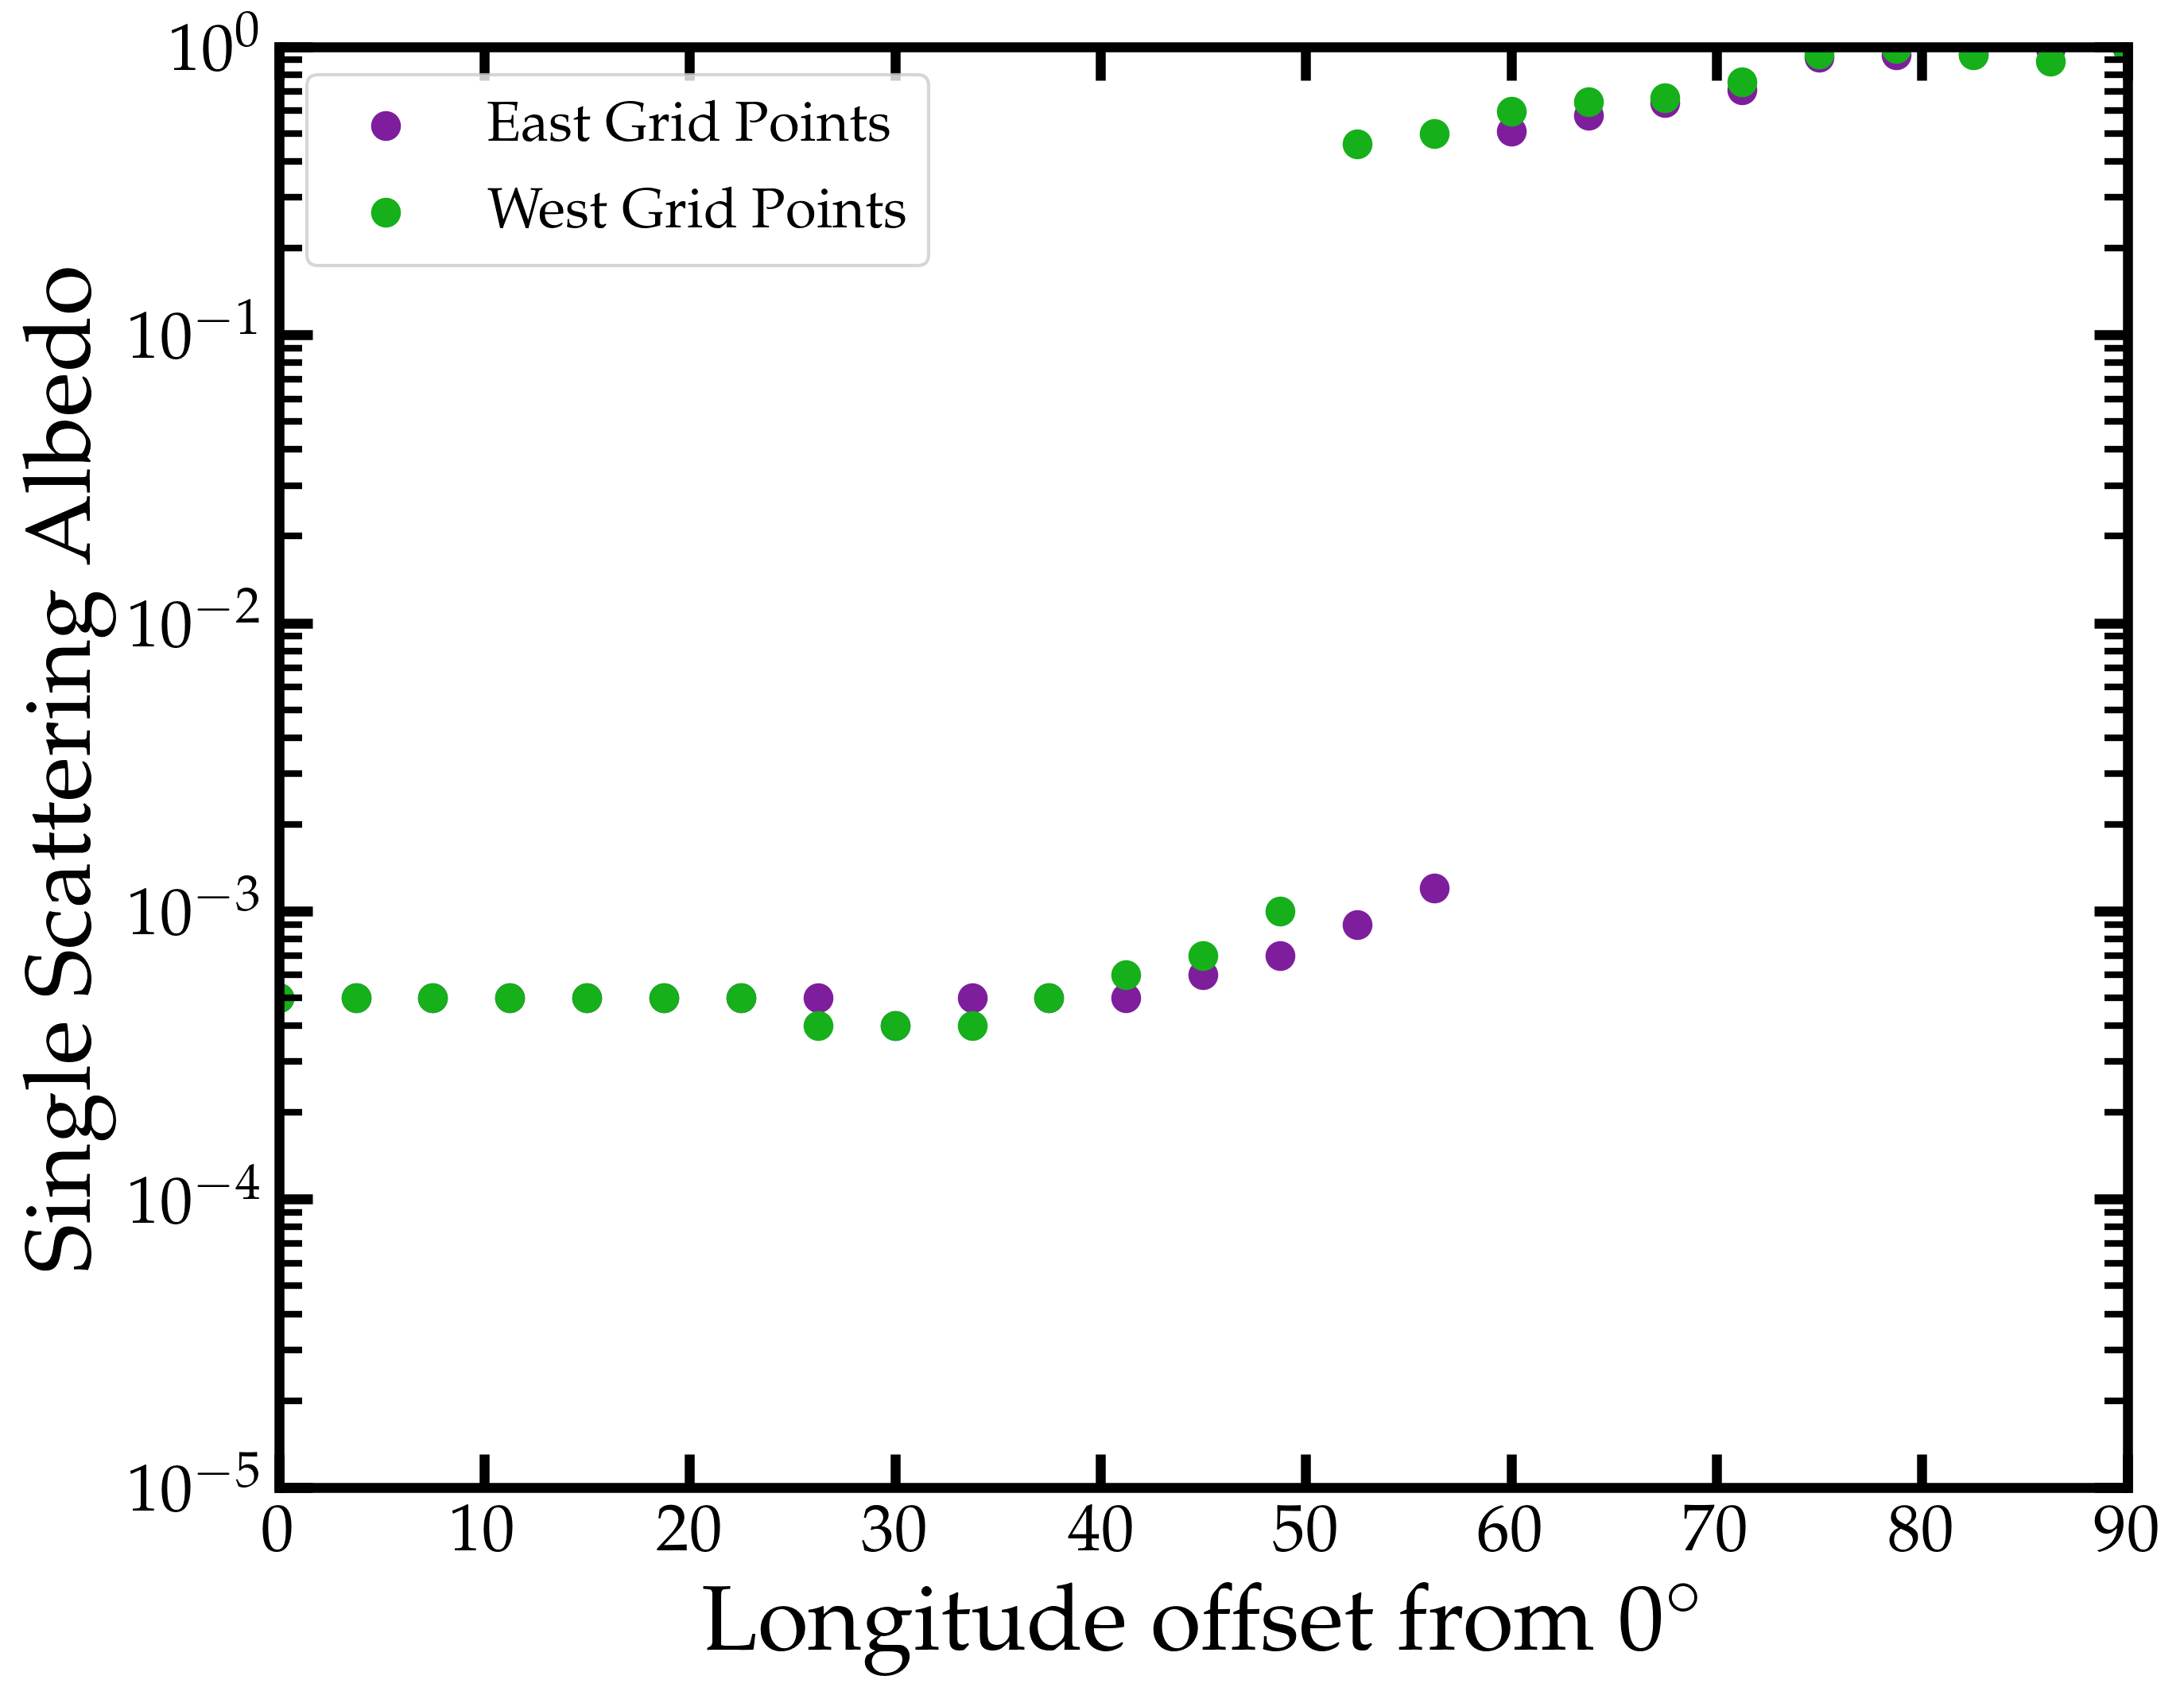

In [44]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,8), sharex=True, sharey=False)
plt.subplots_adjust(wspace=0.2, hspace=0.1)

spots = df[(df.lat > 1.85) & (df.lat < 1.86)].reset_index(drop=True)

ax.scatter(spots.lon, spots.w0_sw, label='East Grid Points', color='#7e1e9c', linewidth=3)
ax.scatter(-1 * spots.lon, spots.w0_sw, label='West Grid Points', color='#15b01a', linewidth=3)
ax.legend()

ax.set_yscale('log')
ax.set_xlim(0,90)
ax.set_ylim(1e-5,1)
ax.set_ylabel('Single Scattering Albedo')
ax.set_xlabel(r'Longitude offset from 0$^{\circ}$')

In [45]:
base = '../Spectral-Processing/GCM-OUTPUT/'
planet_name = 'HD209-PICKET'

column_names = ['lat', 'lon', 'level',
               'alt', 'pres', 'temp', 
               'u', 'v', 'w']

planet_df = pd.read_csv(base + planet_name + '.txt', delim_whitespace=True, names=column_names)

planet_df.lon = planet_df.lon.mask(planet_df.lon >= 180.0, planet_df.lon - 360.0)

print (sorted(list(set(planet_df.pres))))

[1.17e-05, 1.62e-05, 2.24e-05, 3.09e-05, 4.270000000000001e-05, 5.8899999999999995e-05, 8.13e-05, 0.00011200000000000001, 0.000155, 0.00021400000000000002, 0.000295, 0.000407, 0.000562, 0.000776, 0.00107, 0.00148, 0.0020399999999999997, 0.00282, 0.00389, 0.005370000000000001, 0.007409999999999999, 0.0102, 0.0141, 0.0195, 0.0269, 0.0372, 0.0513, 0.0708, 0.0977, 0.135, 0.18600000000000003, 0.257, 0.355, 0.49, 0.6759999999999999, 0.9329999999999999, 1.29, 1.78, 2.45, 3.39, 4.68, 6.46, 8.91, 12.3, 17.0, 23.4, 32.4, 44.7, 61.7, 85.1]


Text(0, 0.5, 'Latitude (degrees)')

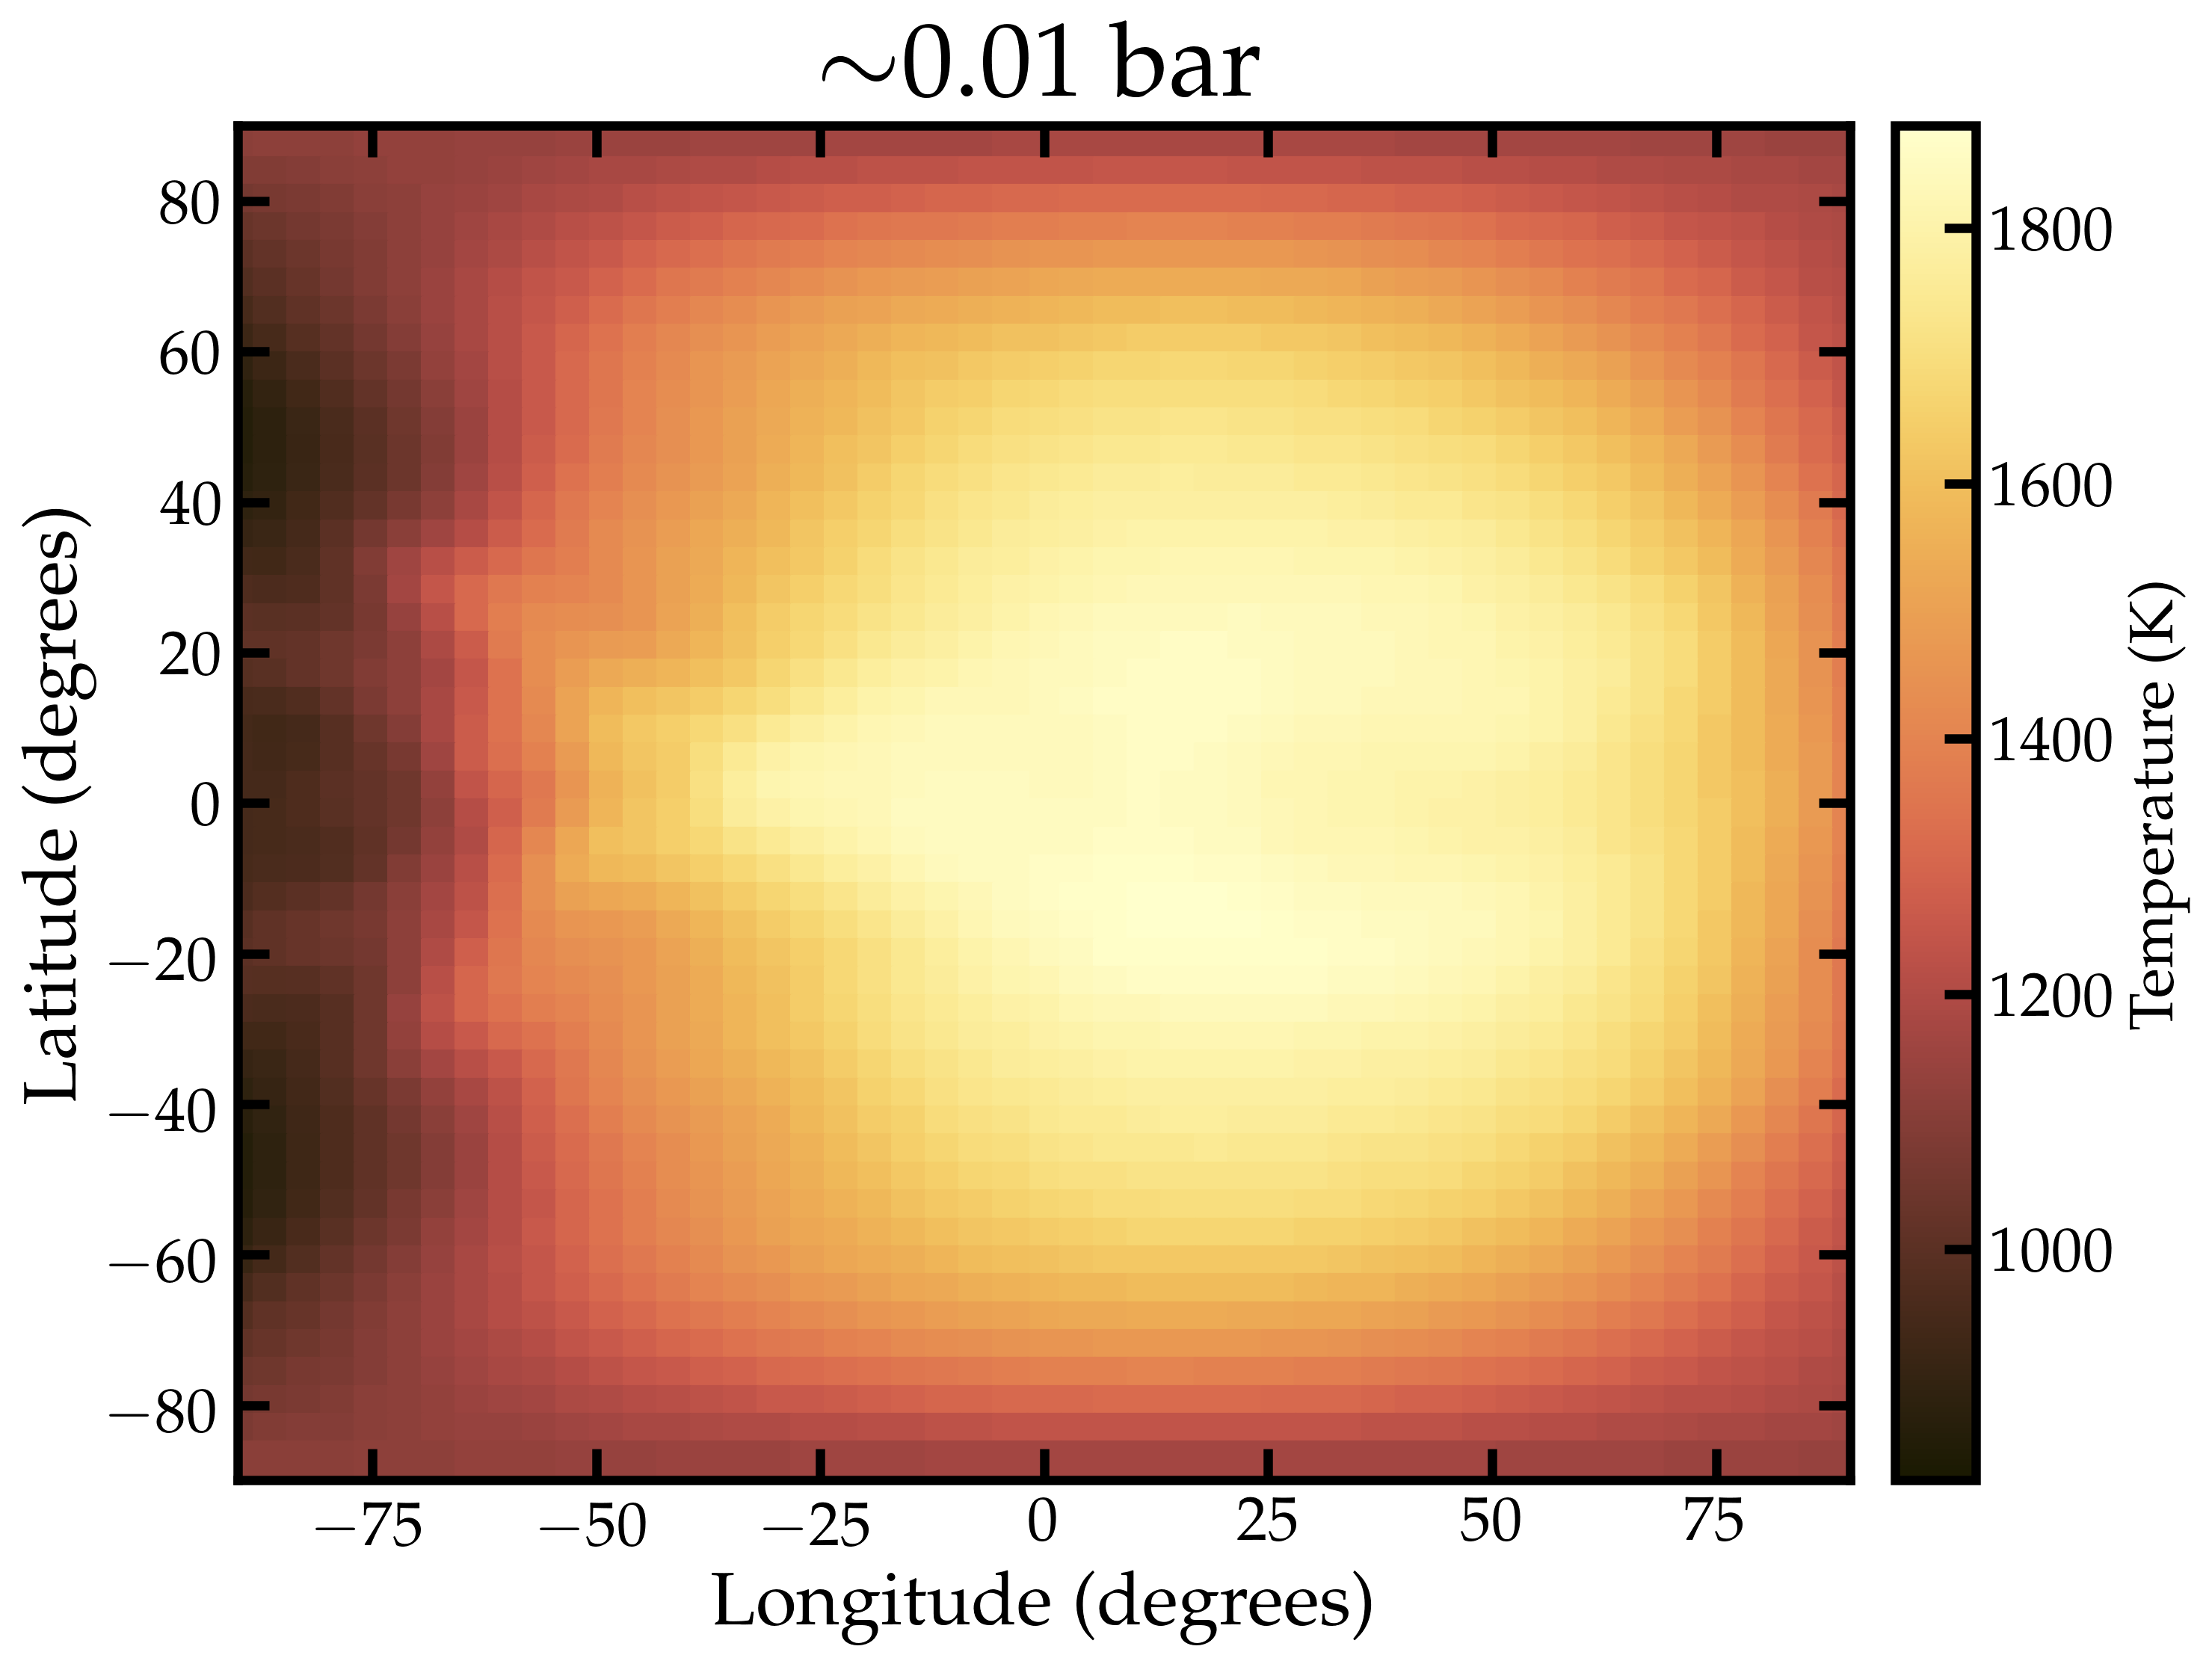

In [46]:
#df = planet_df[planet_df.pres == 0.0977]
df = planet_df[planet_df.pres == 0.0102]


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,8), sharex=True, sharey=False)
plt.subplots_adjust(wspace=0.2, hspace=0.1)

# temp colormap
cm_name = 'lajolla'
cm_file = np.loadtxt(f'../../ScientificColourMaps7/{cm_name}/{cm_name}.txt')
cm_file = np.flip(cm_file, axis=0)
temperature_colors = mcolors.LinearSegmentedColormap.from_list(cm_name, cm_file)


temp_map = ax.scatter(df.lon, df.lat, c=df.temp, marker='s', s=120, cmap=temperature_colors)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.2)
cbar0 = fig.colorbar(temp_map, cax=cax, orientation='vertical')
cbar0.set_label(r'Temperature (K)', fontsize=20)

ax.set_xlim(-90,90)
ax.set_ylim(-90,90)

ax.set_title(r'$\sim$0.01 bar')
ax.set_xlabel('Longitude (degrees)', fontsize=24)
ax.set_ylabel(r'Latitude (degrees)', fontsize=24)

Text(0.5, 0, 'Temperature (K)')

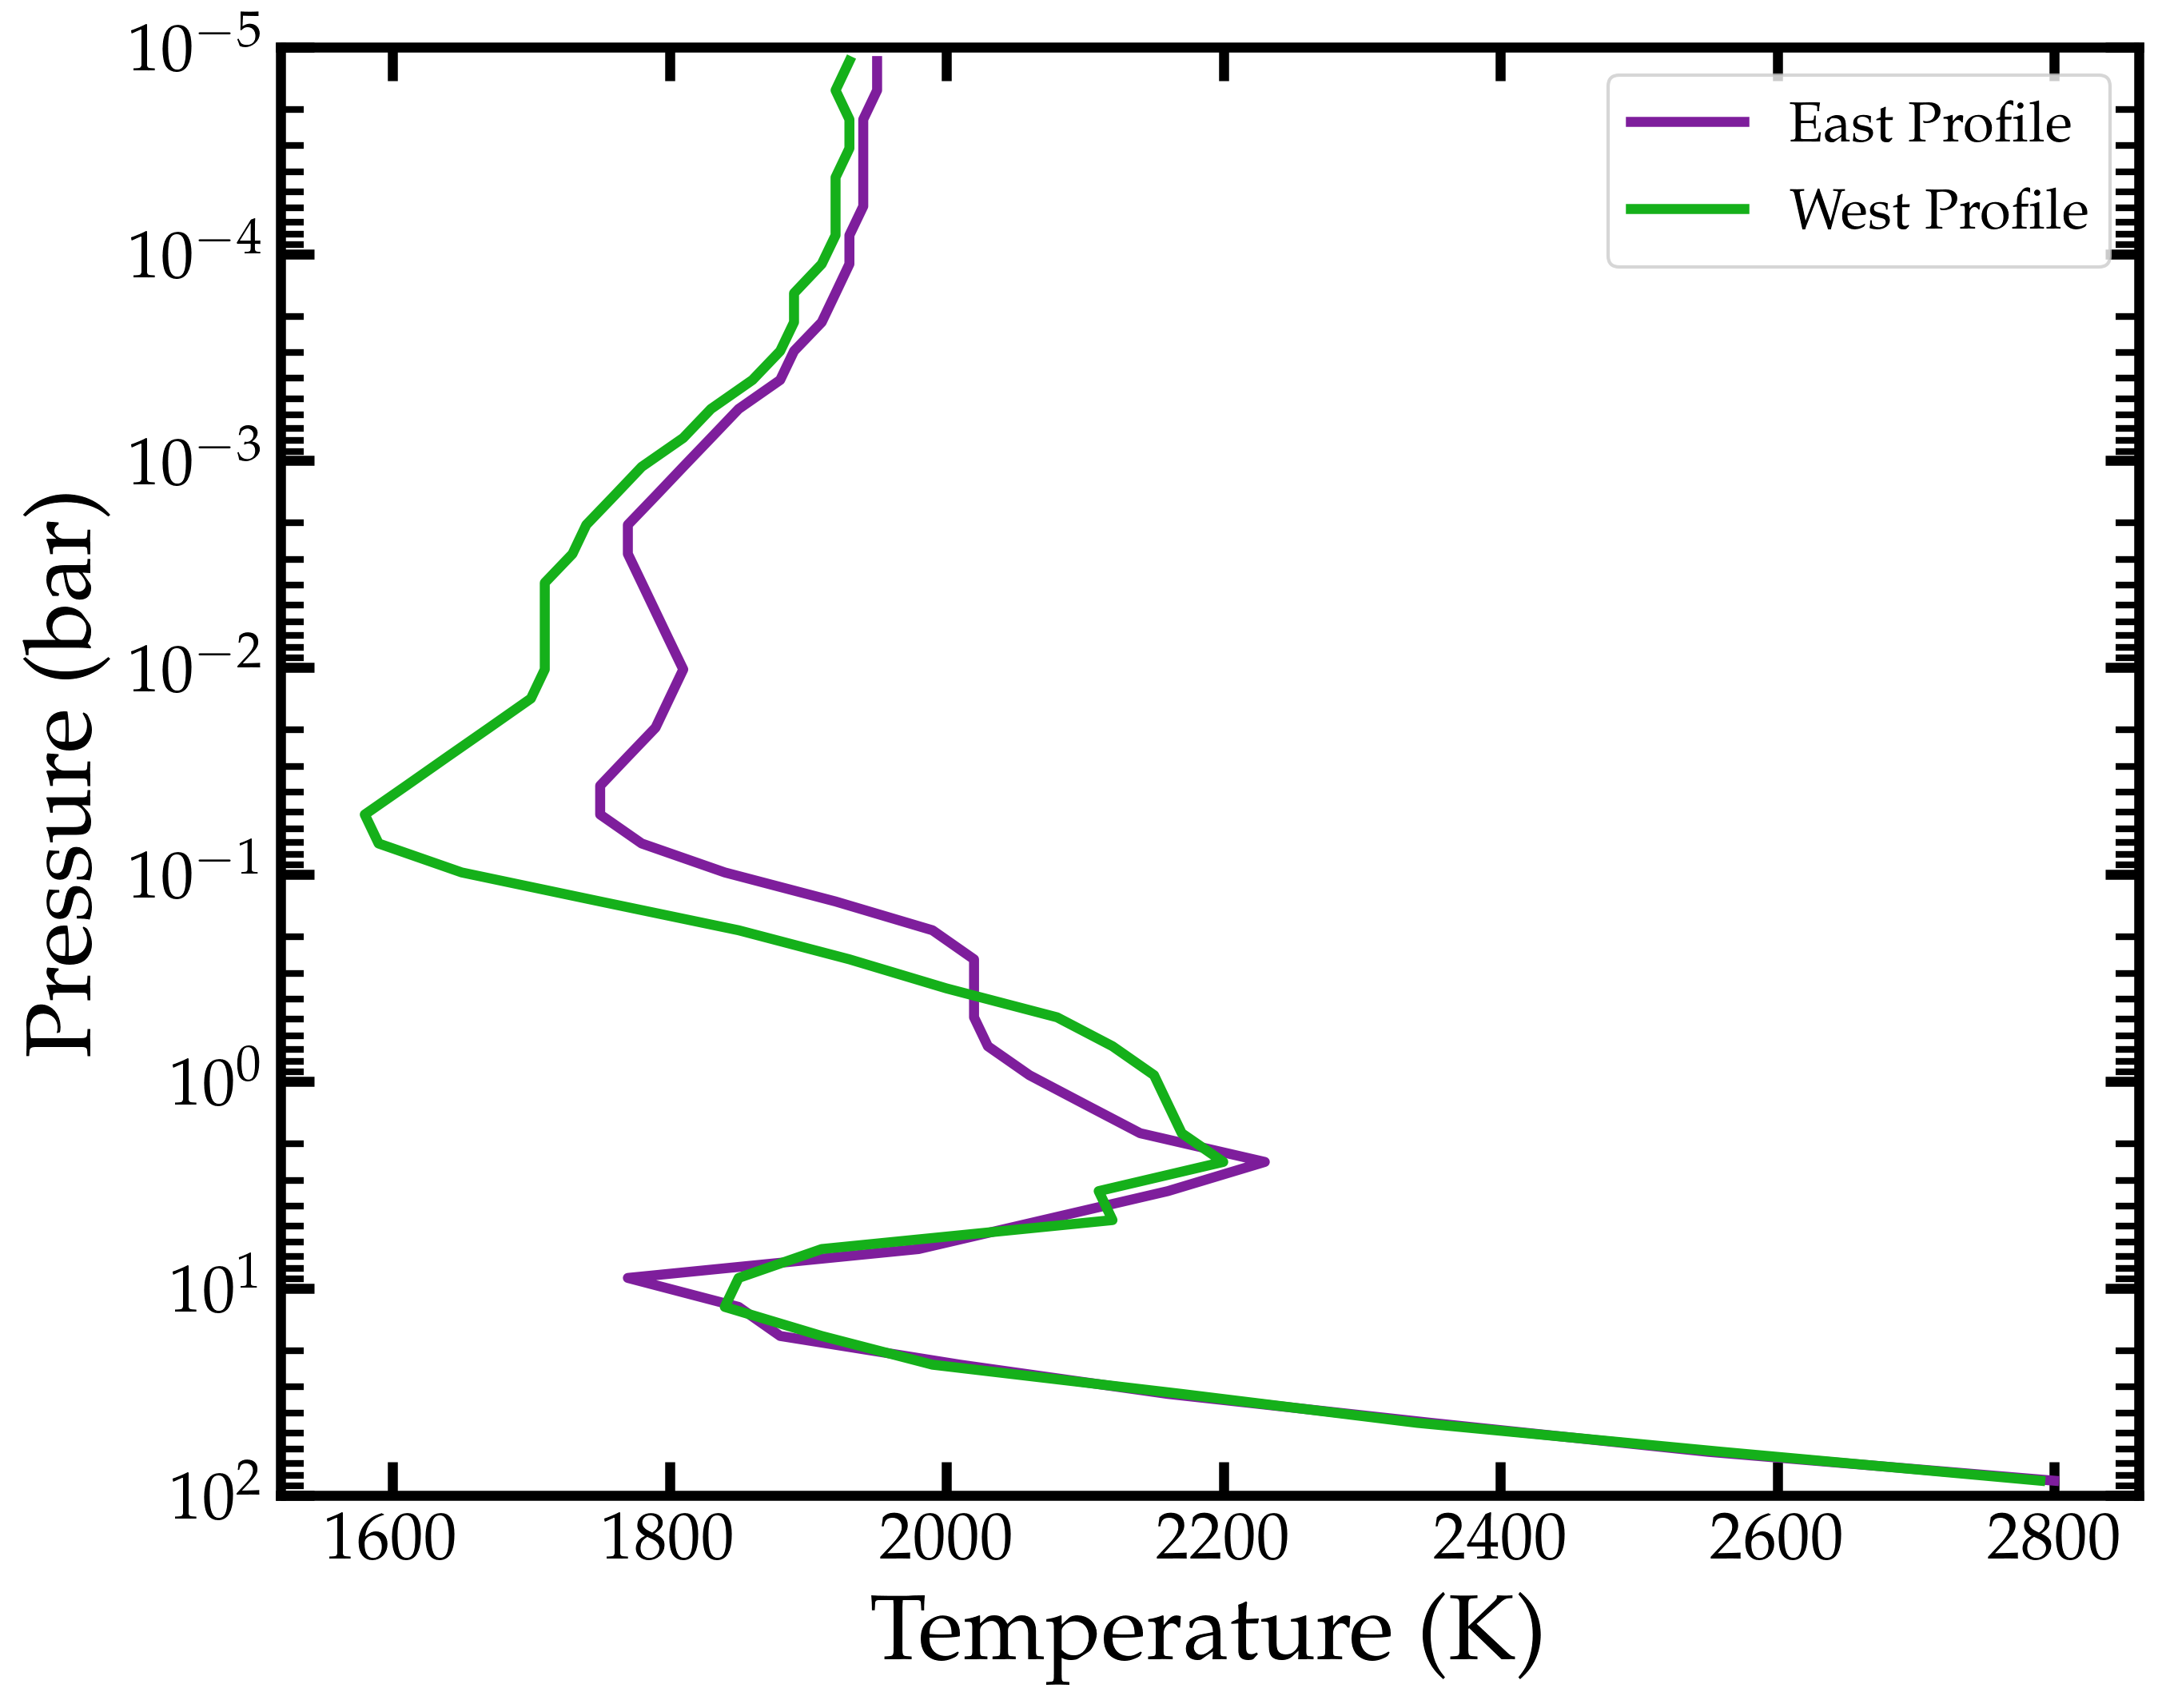

In [47]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,8), sharex=True, sharey=False)
plt.subplots_adjust(wspace=0.2, hspace=0.1)

east_profile = planet_df[(planet_df.lat == 1.86) & (planet_df.lon == 37.5)].reset_index(drop=True)
west_profile = planet_df[(planet_df.lat == 1.86) & (-1 * planet_df.lon == 37.5)].reset_index(drop=True)

ax.plot(east_profile.temp, east_profile.pres, label='East Profile', color='#7e1e9c', linewidth=3)
ax.plot(west_profile.temp, west_profile.pres, label='West Profile', color='#15b01a', linewidth=3)

ax.set_yscale('log')
ax.set_ylim(1e2, 1e-5)
ax.legend()
ax.set_ylabel('Pressure (bar)')
ax.set_xlabel('Temperature (K)')

Text(0.5, 0, 'Atmosphere Layer')

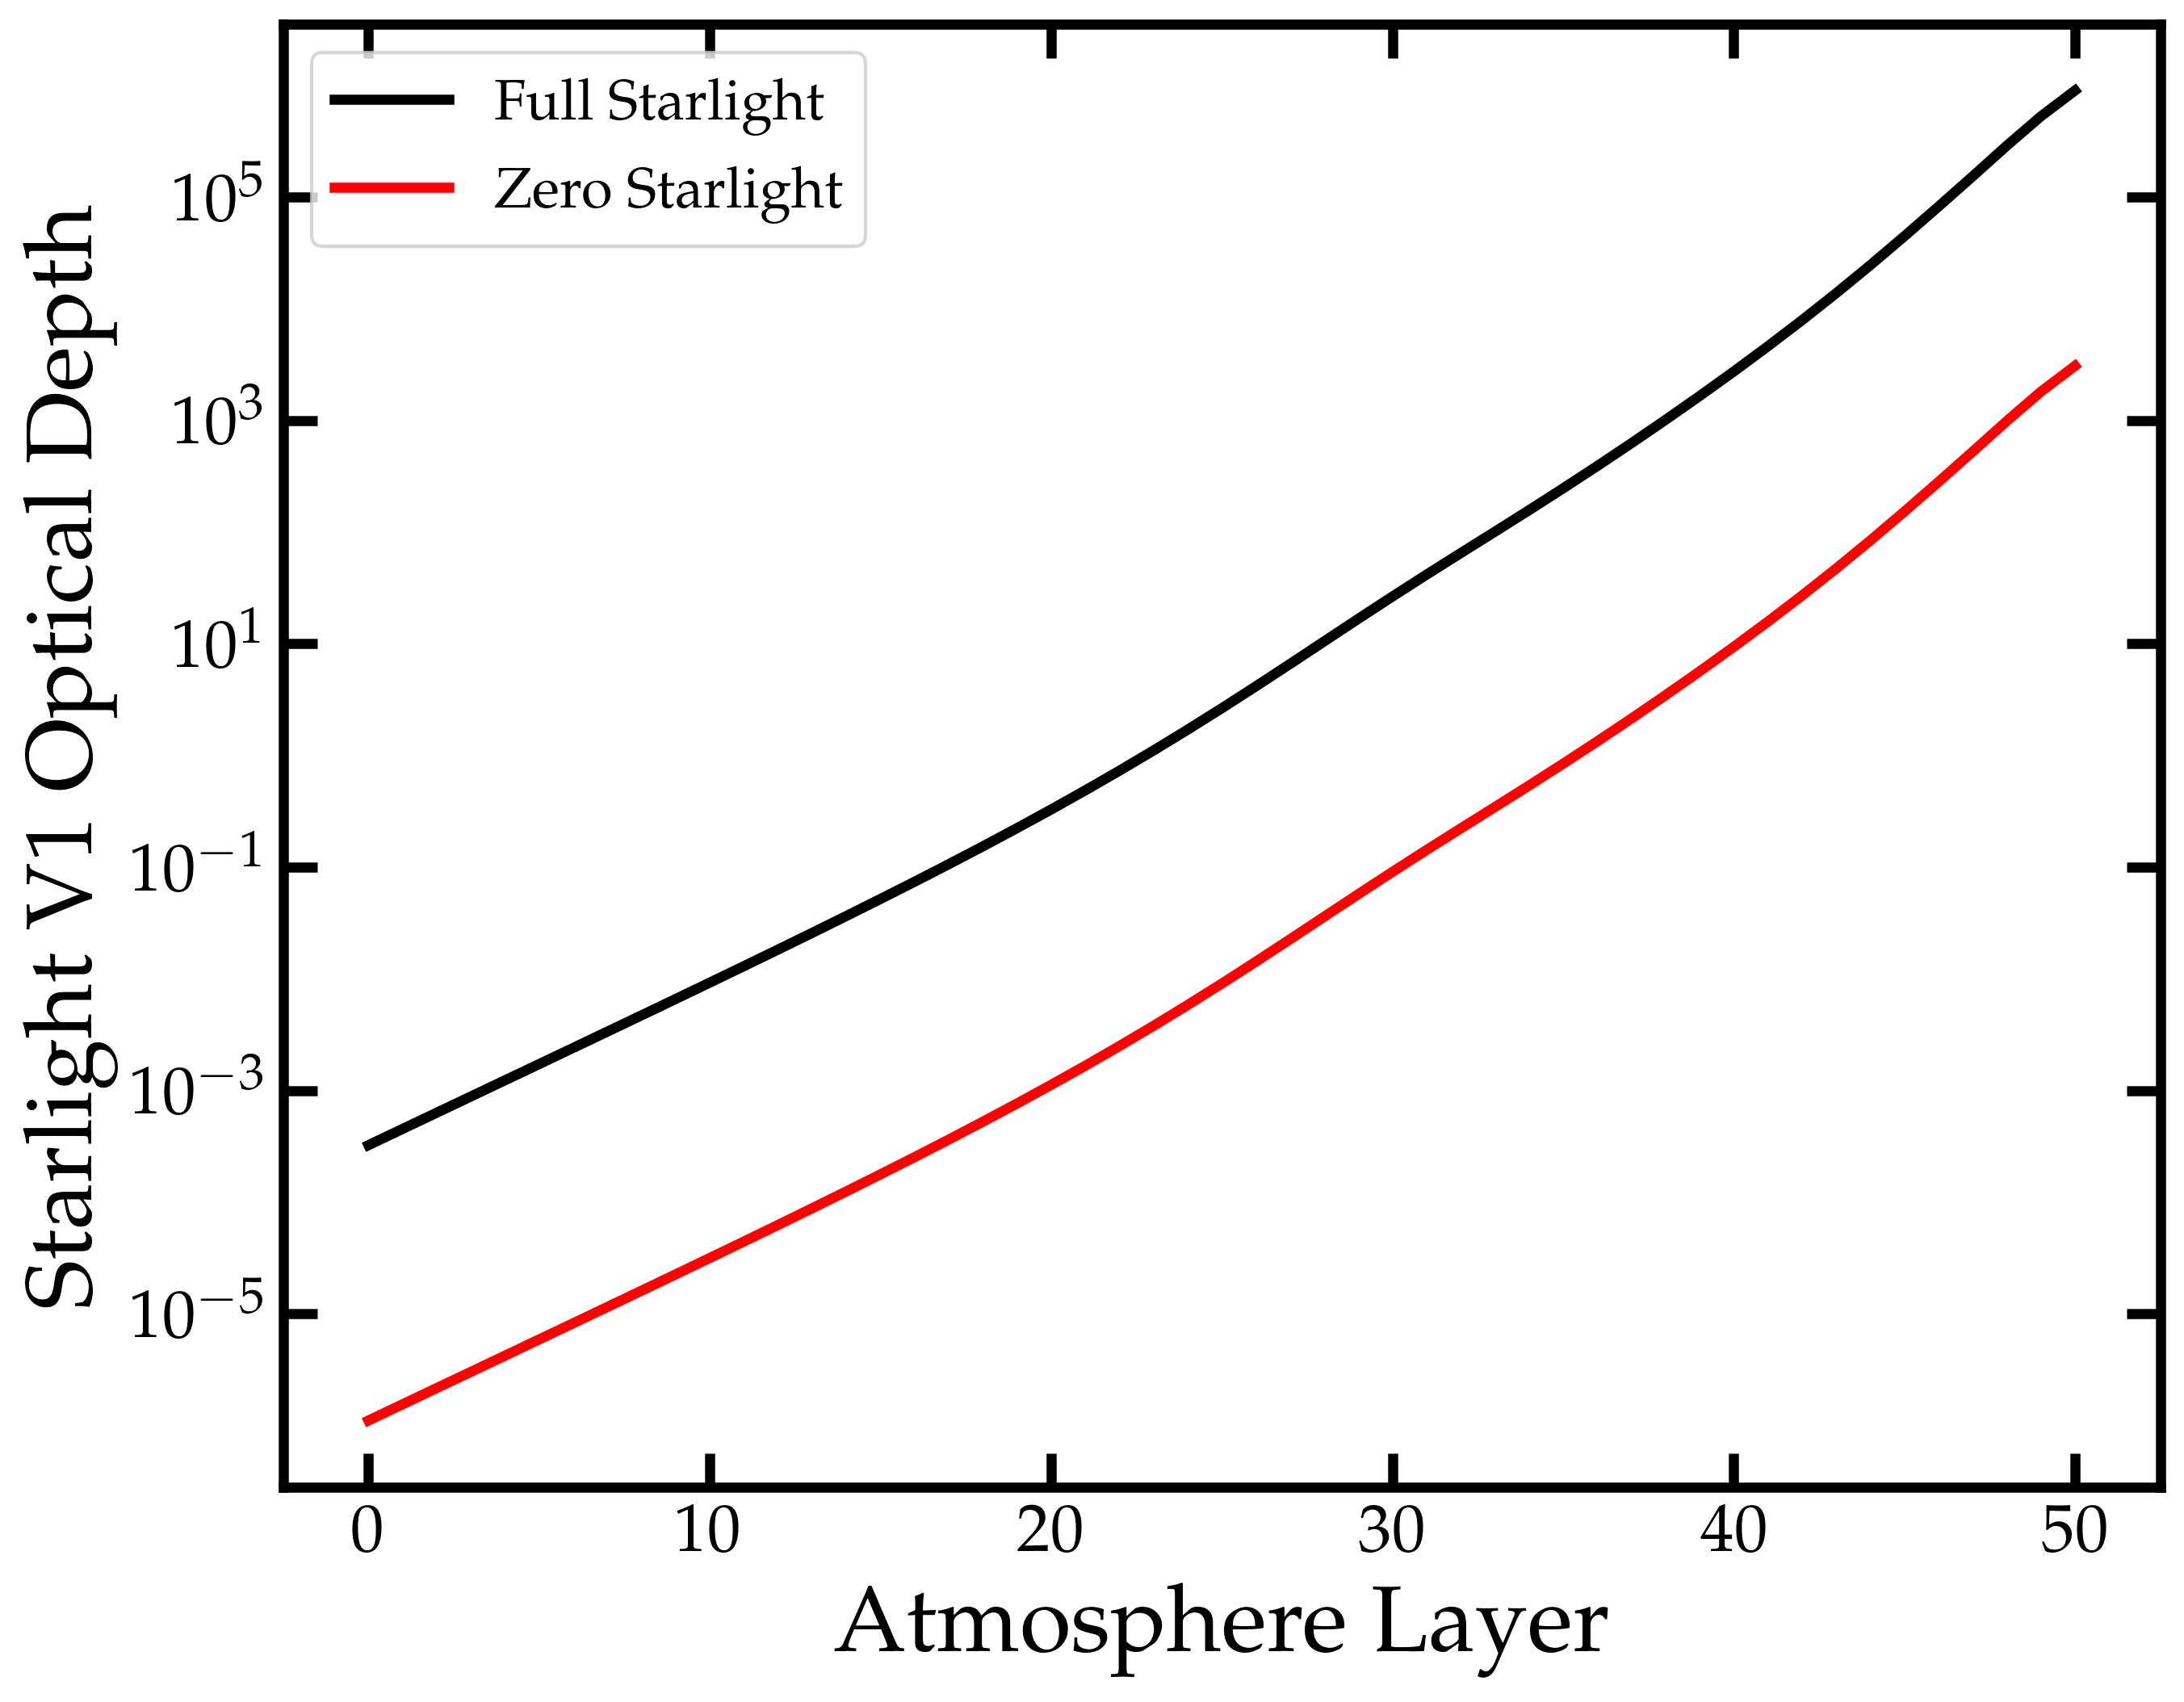

In [48]:
full_starlight = [3.240151157014772E-004,4.528240021799108E-004,6.325838071881652E-004,
8.835467526786663E-004,1.233985411549287E-003,1.723652594855990E-003,
2.408381456418248E-003,3.366755588424579E-003,4.709942704812402E-003,
6.595370874230911E-003,9.247515882939818E-003,1.298735982268053E-002,
1.827705862431922E-002,2.578727715033872E-002,3.649782191772052E-002,
5.185535283589463E-002,7.401515272748714E-002,0.106229227404048,
0.153467948207656,0.223406043579142,0.328092758916892,
0.486669222013604,0.729882288430780,1.10772113380324,
1.70202742840493,2.64703613464374,4.16184649819024,
6.59903204371040,10.5111180541424,16.7353680250895,
26.5024004072424,41.6185700492520,64.8609649293666,
100.773871205373,157.024798868662,246.473446294826,
390.515691578054,625.017360518622,1011.04746109182,
1654.45696715847,2742.41051536286,4613.69633578422,
7896.62398187249,13781.7326282622,24556.2072782329,
44619.4368298094,82338.2808189679,153466.659366751,
288733.339452781,528876.298711662,901283.520885166]
zero_starlight = [1.108041086866634E-006,1.548531458010740E-006,2.163259722416129E-006,
3.021482815750904E-006,4.219885031074828E-006,5.894409865570407E-006,
8.235991091902493E-006,1.151336261993803E-005,1.610668694397615E-005,
2.255432403500687E-005,3.162391830876667E-005,4.441313875834520E-005,
6.250242942824387E-005,8.818527660085384E-005,1.248123445673912E-004,
1.773308056685687E-004,2.531111244461946E-004,3.632742513723645E-004,
5.248174665032402E-004,7.639861949159016E-004,1.121985486375530E-003,
1.664272645234602E-003,2.495993319344576E-003,3.788096510211323E-003,
5.820457843652439E-003,9.052123353122089E-003,1.423235118905838E-002,
2.256684421080321E-002,3.594508437571122E-002,5.723027870316345E-002,
9.063079815964796E-002,0.142323871191538,0.221806362088886,
0.344618458729673,0.536980901112491,0.842870261546379,
1.33545445988787,2.13738459071652,3.45749958373571,
5.65778016897619,9.37827706432306,15.7775512766044,
27.0042457757202,47.1296716119696,83.9753618993629,
152.585996407123,281.573895007526,524.813059027760,
987.387278427620,1808.60904459280,3082.13760303910]


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,8), sharex=True, sharey=False)
plt.subplots_adjust(wspace=0.2, hspace=0.1)

ax.plot(full_starlight, color='black', label='Full Starlight', linewidth=3)
ax.plot(zero_starlight, color='red', label='Zero Starlight', linewidth=3)

ax.set_yscale('log')
#ax.set_ylim(1e2, 1e-5)
ax.legend()
ax.set_ylabel('Starlight V1 Optical Depth')
ax.set_xlabel('Atmosphere Layer')